In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold

# Configure GPU
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "1"
device = "cpu"


In [2]:
def load_brain_data(npz_path):
    tmp = np.load(npz_path, allow_pickle=True)
    data = tmp['data']
    sections = tmp['sections'].item()
    gene_ids = list(sections.keys())
    gene_names = list(sections.values())
    return data, gene_ids, gene_names

def load_and_reshape_imputed_data(path, shape=(4345, 67, 41, 58)):
    data = np.load(path)
    return data.reshape(shape)

def robust_zscore(data, eps=1e-8, clip=4):
    # data: shape (genes, Z, Y, X)
    g, Z, Y, X = data.shape
    flat = data.reshape(g, -1)  # shape (genes, voxels)
    
    min_ = flat.min(axis=0, keepdims=True)
    max_ = flat.max(axis=0, keepdims=True)
    denom = np.maximum(max_ - min_, eps)  # avoid division by zero
    
    flat = (flat - min_) / denom
    return flat.reshape(data.shape).astype(np.float32)


In [3]:
data_raw, gene_ids, gene_names = load_brain_data("mouse_brain_ISH_float32.npz")
data_imputed = load_and_reshape_imputed_data("imputed.npy")

data_zscored_all = robust_zscore(data_imputed)
# Select highly variable genes
n_top_genes = 3000
gene_variances = np.var(data_zscored_all.reshape(data_zscored_all.shape[0], -1), axis=1)
top_gene_indices = np.argsort(gene_variances)[::-1][:n_top_genes]

data_zscored = data_zscored_all[top_gene_indices]


gene_ids = [gene_ids[i] for i in top_gene_indices]
gene_names = [gene_names[i] for i in top_gene_indices]

print(f"Original data shape: {data_imputed.shape}")
print(f"Z-scored data shape: {data_zscored.shape}")
print(f"Number of genes selected: {len(gene_ids)}")


Original data shape: (4345, 67, 41, 58)
Z-scored data shape: (3000, 67, 41, 58)
Number of genes selected: 3000


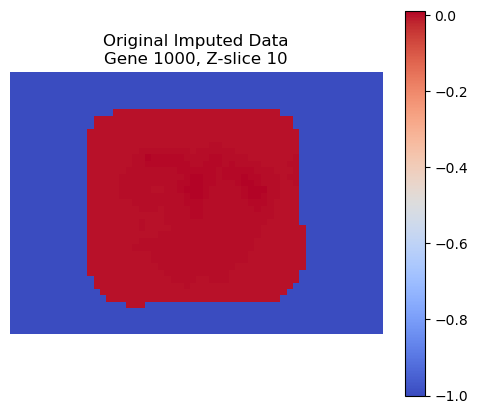

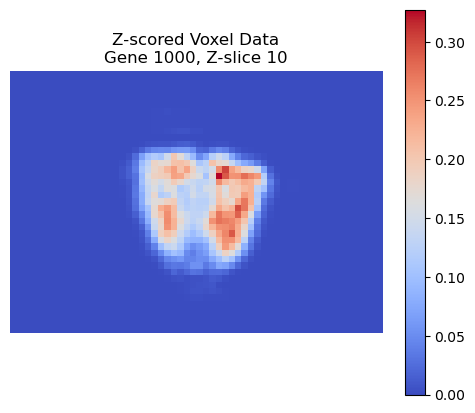

In [4]:
# Re-import everything needed after reset
import os
import numpy as np
import matplotlib.pyplot as plt


def plot_voxel_grid(data, z_index=30, gene_index=0, title="", cmap="coolwarm"):
    slice_2d = data[gene_index, z_index]
    plt.figure(figsize=(6, 5))
    plt.imshow(slice_2d, cmap=cmap)
    plt.colorbar()
    plt.title(f"{title}\nGene {gene_index}, Z-slice {z_index}")
    plt.axis("off")
    plt.show()


# Plot before and after
#plot_voxel_grid(data_raw, z_index=10, gene_index=1000, title="Original raw Data")
plot_voxel_grid(data_imputed, z_index=10, gene_index=1000, title="Original Imputed Data")
plot_voxel_grid(data_zscored, z_index=10, gene_index=1000, title="Z-scored Voxel Data")


In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# Flatten the spatial dimensions
data_flat = data_zscored.reshape(3000, 67* 41* 58).T

# Clustering
num_clusters = 12  # Example number of clusters, adjust based on your analysis
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(data_flat)
clusters = kmeans.labels_

# Reshape the cluster assignments to the original spatial dimensions
z_dim, y_dim, x_dim = data_zscored.shape[1:]
clusters_reshaped = clusters.reshape(z_dim, y_dim, x_dim)

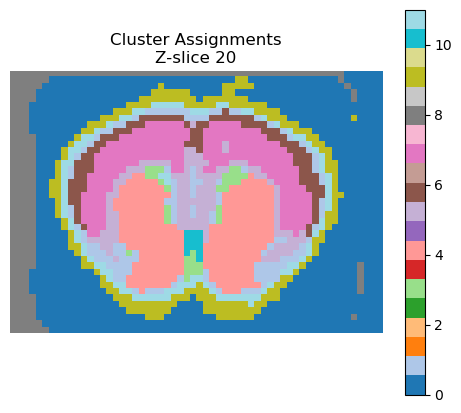

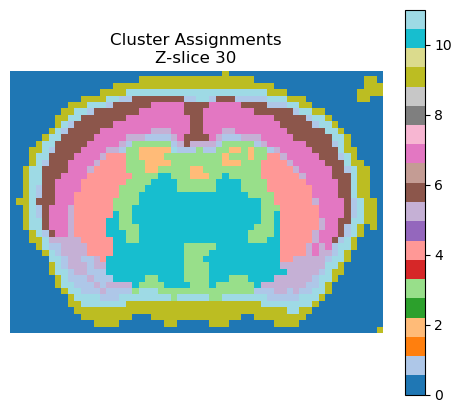

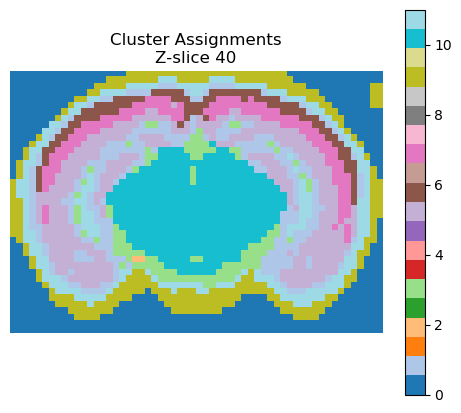

In [6]:
#show the cluster on a slice
def plot_cluster_slice(clusters, z_index=30, title="Cluster Assignments", cmap="tab20"):
    plt.figure(figsize=(6, 5))
    plt.imshow(clusters[z_index], cmap=cmap)
    plt.colorbar()
    plt.title(f"{title}\nZ-slice {z_index}")
    plt.axis("off")
    plt.show()

# Plot the cluster assignments for a specific z-slice
plot_cluster_slice(clusters_reshaped, z_index=20, title="Cluster Assignments", cmap="tab20")
plot_cluster_slice(clusters_reshaped, z_index=30, title="Cluster Assignments", cmap="tab20")
plot_cluster_slice(clusters_reshaped, z_index=40, title="Cluster Assignments", cmap="tab20")

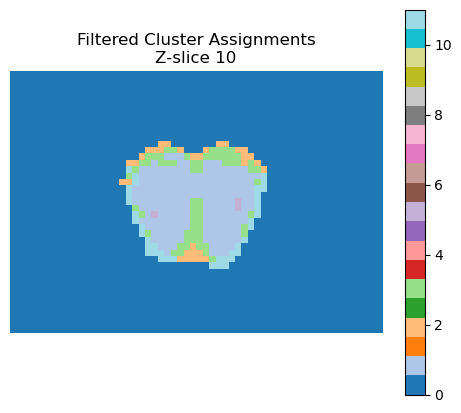

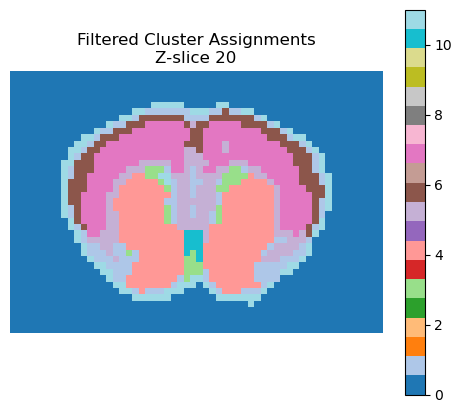

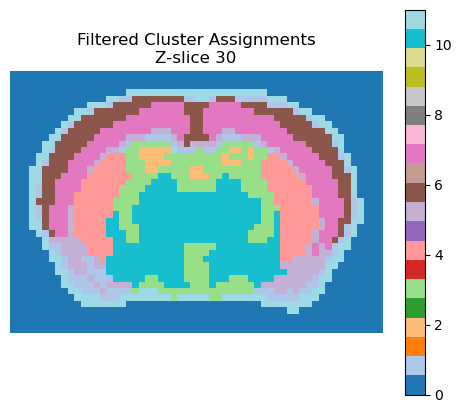

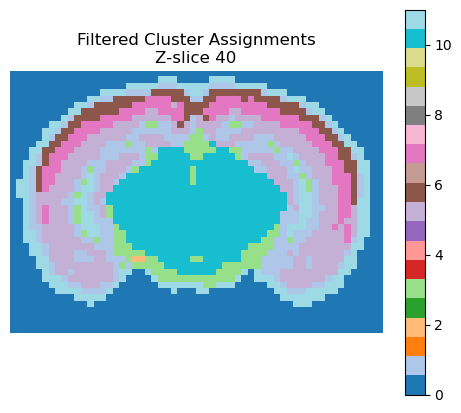

In [7]:
#remove the dark brown and light green
def remove_clusters(clusters, unwanted_clusters):
    mask = np.isin(clusters, unwanted_clusters, invert=True)
    return clusters * mask
# Define unwanted clusters (e.g., dark brown and light green)
unwanted_clusters = [0,8,9]  # Adjust based on your clustering results
# Remove unwanted clusters
clusters_filtered = remove_clusters(clusters_reshaped, unwanted_clusters)
# Plot the filtered cluster assignments for a specific z-slice
plot_cluster_slice(clusters_filtered, z_index=10, title="Filtered Cluster Assignments", cmap="tab20")
plot_cluster_slice(clusters_filtered, z_index=20, title="Filtered Cluster Assignments", cmap="tab20")
plot_cluster_slice(clusters_filtered, z_index=30, title="Filtered Cluster Assignments", cmap="tab20")
plot_cluster_slice(clusters_filtered, z_index=40, title="Filtered Cluster Assignments", cmap="tab20")

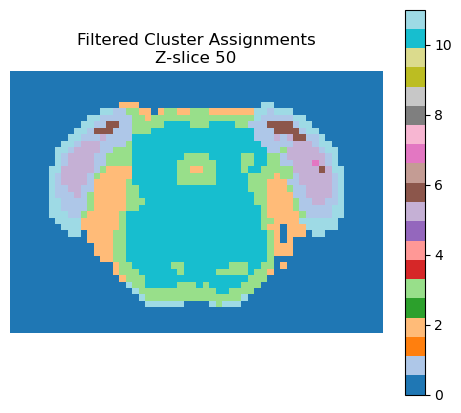

In [8]:
plot_cluster_slice(clusters_filtered, z_index=50, title="Filtered Cluster Assignments", cmap="tab20")


In [9]:
import numpy as np

# ---- 0. inputs --------------------------------------------------------------
# clusters_reshaped : (67, 41, 58)  int/uint   – full cluster map
# data              : (4345, 67, 41, 58) float – gene-by-voxel expression
unwanted_clusters = [0,8,9]       # tuple or list is fine

# ---- 1. build a boolean voxel mask for unwanted clusters -------------------
bad_voxel_mask = np.isin(clusters_reshaped, unwanted_clusters)      # shape (67,41,58)

# ---- 2. update the cluster map itself (optional but tidy) ------------------
clusters_clean = np.where(bad_voxel_mask, -1, clusters_reshaped)    # same shape, -1 for bad

# ---- 3. broadcast mask to all genes and write –1 into the data tensor ------
#     – in-place if you want to save RAM (remove the .copy()).
data_clean = data_zscored.copy()                                            # keep original
data_clean[:, bad_voxel_mask] = -1.0    

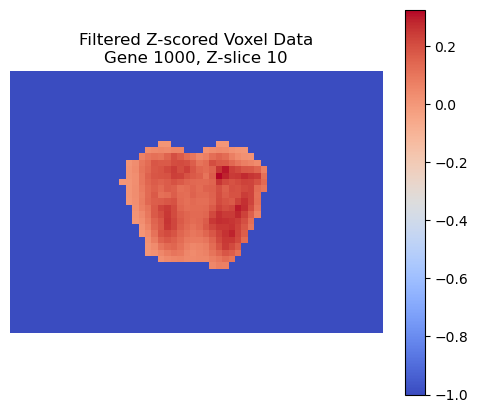

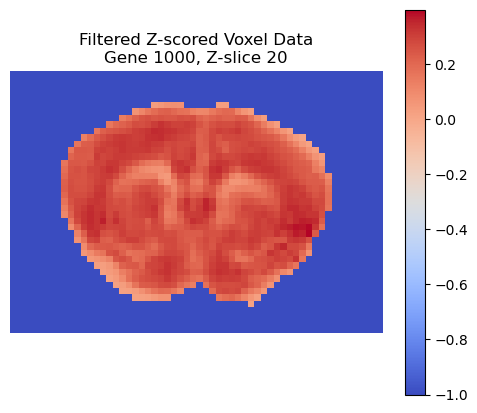

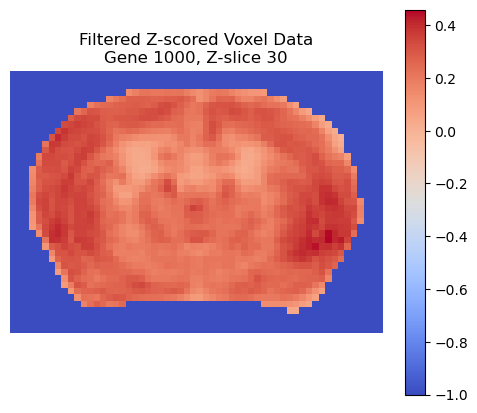

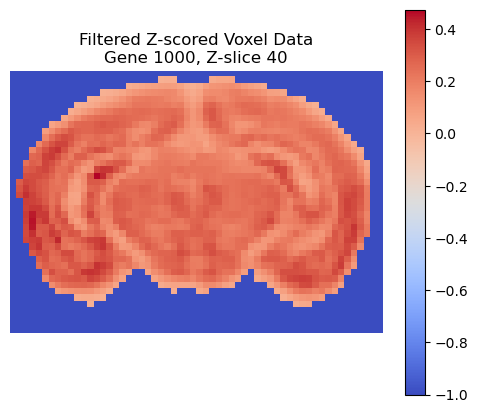

In [10]:
# Plot the filtered data
plot_voxel_grid(data_clean, z_index=10, gene_index=1000, title="Filtered Z-scored Voxel Data")
plot_voxel_grid(data_clean, z_index=20, gene_index=1000, title="Filtered Z-scored Voxel Data")
plot_voxel_grid(data_clean, z_index=30, gene_index=1000, title="Filtered Z-scored Voxel Data")
plot_voxel_grid(data_clean, z_index=40, gene_index=1000, title="Filtered Z-scored Voxel Data")

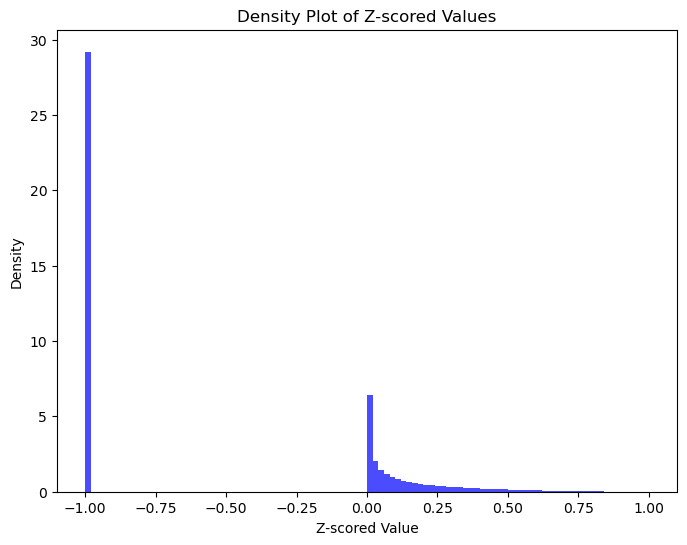

In [11]:
#data_zscored as a denisty function of values for teh wwhole brain
def plot_density(data, title="Density Plot of Z-scored Values"):
    plt.figure(figsize=(8, 6))
    plt.hist(data.flatten(), bins=100, density=True, alpha=0.7, color='blue')
    plt.title(title)
    plt.xlabel("Z-scored Value")
    plt.ylabel("Density")
    plt.show()

# Plot the density of z-scored values
plot_density(data_clean, title="Density Plot of Z-scored Values")


In [12]:
import numpy as np
from sklearn.model_selection import KFold
import torch
from torch.utils.data import TensorDataset, DataLoader

def build_cleaned_grouped(data_clean):
    """
    Efficiently build a dict mapping (z,y,x) → (gene_indices, values).
    Only stores non-missing/non-masked gene indices and values.
    """
    n_genes, Z, Y, X = data_clean.shape
    # Get mask of valid voxels (at least one gene is present)
    valid_voxels = np.any((data_clean != -1.0) & (~np.isnan(data_clean)), axis=0)
    zyx_idx = np.array(np.where(valid_voxels)).T

    # Build dict using advanced indexing, no python for-loops
    grouped = {}
    for z, y, x in zyx_idx:
        expr = data_clean[:, z, y, x]
        mask = (expr != -1.0) & (~np.isnan(expr))
        idx = np.flatnonzero(mask)
        if idx.size > 0:
            grouped[(z, y, x)] = (idx, expr[idx].astype(np.float32))
    return grouped

def make_kfold_splits_vec(grouped, n_splits=5, seed=42):
    """
    Vectorized 5-fold CV on voxel keys.
    """
    keys = np.array(list(grouped.keys()))
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    folds = []
    for train_val_idx, test_idx in kf.split(keys):
        test_keys = keys[test_idx]
        train_val_keys = keys[train_val_idx]
        # Validation set
        n_val = len(train_val_keys) // n_splits
        val_keys = train_val_keys[:n_val]
        train_keys = train_val_keys[n_val:]
        # Fast dict comprehensions
        train_dict = {tuple(k): grouped[tuple(k)] for k in train_keys}
        val_dict = {tuple(k): grouped[tuple(k)] for k in val_keys}
        test_dict = {tuple(k): grouped[tuple(k)] for k in test_keys}
        folds.append((train_dict, val_dict, test_dict))
    return folds

# Main efficient preprocessing pipeline
def preprocessing_to_folds(data_clean, n_splits=5, seed=42):
    grouped = build_cleaned_grouped(data_clean)
    folds = make_kfold_splits_vec(grouped, n_splits=n_splits, seed=seed)
    return folds

# Assume data_clean is already in memory, shape = (n_genes, Z, Y, X)
folds = preprocessing_to_folds(data_clean, n_splits=5)
print(f"Fold 1 sizes → Train: {len(folds[0][0])}, Val: {len(folds[0][1])}, Test: {len(folds[0][2])}")


Fold 1 sizes → Train: 42425, Val: 10606, Test: 13258


In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader

def dict_to_tensor_collapsed(grouped, n_genes, shape):
    """
    shape = (Z_dim, Y_dim, X_dim)
    Returns X, z_coll, y, x as tensors.
    More time-efficient vectorized version.
    """
    n_samples = len(grouped)
    X = torch.zeros((n_samples, n_genes), dtype=torch.float32)
    Zs = torch.empty(n_samples, dtype=torch.long)
    Ys = torch.empty(n_samples, dtype=torch.long)
    Xps = torch.empty(n_samples, dtype=torch.long)

    for i, ((z, y, x), (indices, vals_expr)) in enumerate(grouped.items()):
        if indices is not None:
            X[i, indices] = torch.tensor(vals_expr, dtype=torch.float32)
        Zs[i] = z
        Ys[i] = y
        Xps[i] = x

    return X, Zs, Ys, Xps

def make_dataloader_collapsed(grouped, n_genes, shape, batch_size=128, shuffle=True):
    X, Zc, Y, Xp = dict_to_tensor_collapsed(grouped, n_genes, shape)
    ds = TensorDataset(X, Zc, Y, Xp)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

In [14]:
class PathwayVAE_cls_reg(nn.Module):
    def __init__(self,num_genes, latent_dim: int = 50,
                 neg_slope: float = 0.01, shape=(67, 41, 58)):
        super().__init__()
        Z_dim, Y_dim, X_dim = shape
        self.act = nn.LeakyReLU()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(num_genes, 1000),
            nn.BatchNorm1d(1000),
            self.act,
            nn.Dropout(0.7),
            nn.Linear(1000, 500),
            nn.BatchNorm1d(500),
            self.act
            
        )
        self.fc_mu     = nn.Linear(500, latent_dim)
        self.fc_logvar = nn.Linear(500, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 500),
            nn.Linear(500, num_genes)
        )

        # Classification heads
        def make_head(out_dim):
            return nn.Sequential(
                nn.Linear(latent_dim, 64),
                nn.BatchNorm1d(64),
                self.act,
                nn.Dropout(0.0),
                nn.Linear(64, out_dim)
            )
        self.cls_z = make_head(Z_dim)
        self.cls_y = make_head(Y_dim)
        self.cls_x = make_head(X_dim)

        # Regression heads
        self.reg_x = nn.Linear(latent_dim, 1)
        self.reg_y = nn.Linear(latent_dim, 1)
        self.reg_z = nn.Linear(latent_dim, 1)

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + torch.randn_like(std) * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon    = self.decode(z)
        z_logits = self.cls_z(z)
        y_logits = self.cls_y(z)
        x_logits = self.cls_x(z)
        x_reg    = self.reg_x(z)
        y_reg    = self.reg_y(z)
        z_reg    = self.reg_z(z)
        return recon, mu, logvar, z_logits, y_logits, x_logits, x_reg, y_reg, z_reg


In [50]:
ce_loss = nn.CrossEntropyLoss(ignore_index=-1)

def loss_fn_cls_reg(
    recon, x_true, mu, logvar,
    z_logits, z_true, y_logits, y_true, x_logits, x_true_pos,
    x_reg, y_reg, z_reg,
    epoch=None, total_epochs=None,
    w_recon=1e6, w_kld=1, w_cls=10, w_reg=100
):

    recon_l = F.mse_loss(recon, x_true)
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    lz = ce_loss(z_logits, z_true)
    ly = ce_loss(y_logits, y_true)
    lx = ce_loss(x_logits, x_true_pos)
    rx = F.mse_loss(x_reg.squeeze(), x_true_pos.float())
    ry = F.mse_loss(y_reg.squeeze(), y_true.float())
    rz = F.mse_loss(z_reg.squeeze(), z_true.float())
    predicted_positions = torch.stack([x_reg.squeeze(), y_reg.squeeze(), z_reg.squeeze()], dim=1)
    true_positions = torch.stack([x_true_pos.float(), y_true.float(), z_true.float()], dim=1)
    position_euclidean = torch.norm(predicted_positions - true_positions, dim=1).mean()
    total = (
        w_recon * recon_l +
        w_kld   * kld +
        #w_cls * (lz + ly + lx) +
        w_reg  * (rx + ry + rz) +
        w_reg   * position_euclidean
    )
    return total, {
        "recon": recon_l.item(), "kld": kld.item(),
        "lz": lz.item(), "ly": ly.item(), "lx": lx.item(),
        "rx": rx.item(), "ry": ry.item(), "rz": rz.item()
    }

In [51]:
def train_pathway_vae_cls_reg(model, train_loader, val_loader, optimizer, device, loss_fn, epochs=50, save_path="best_model.pth"):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    history = {k: [] for k in [
        "train_total","val_total",
        "train_recon","val_recon",
        "train_kld","val_kld",
        "train_lz","val_lz","train_ly","val_ly","train_lx","val_lx",
        "train_rx","val_rx","train_ry","val_ry","train_rz","val_rz"
    ]}
    best_val_loss = float('inf')

    for ep in range(1, epochs+1):
        # Training
        model.train()
        acc = {k: 0.0 for k in history if k.startswith("train_")}
        for x, z, y, xp in train_loader:
            x, z, y, xp = x.to(device), z.to(device), y.to(device), xp.to(device)
            optimizer.zero_grad()
            recon, mu, logvar, zl, yl, xl, xr, yr, zr = model(x)
            loss, parts = loss_fn(
                recon, x, mu, logvar,
                zl, z, yl, y, xl, xp,
                xr, yr, zr
            )
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            acc["train_total"] += loss.item()
            acc["train_recon"] += parts["recon"]
            acc["train_kld"]   += parts["kld"]
            acc["train_lz"]    += parts["lz"]
            acc["train_ly"]    += parts["ly"]
            acc["train_lx"]    += parts["lx"]
            acc["train_rx"]    += parts["rx"]
            acc["train_ry"]    += parts["ry"]
            acc["train_rz"]    += parts["rz"]
        n = len(train_loader)
        for k in acc: history[k].append(acc[k]/n)

        # Validation
        model.eval()
        acc = {k: 0.0 for k in history if k.startswith("val_")}
        with torch.no_grad():
            for x, z, y, xp in val_loader:
                x, z, y, xp = x.to(device), z.to(device), y.to(device), xp.to(device)
                recon, mu, logvar, zl, yl, xl, xr, yr, zr = model(x)
                loss, parts = loss_fn(
                    recon, x, mu, logvar,
                    zl, z, yl, y, xl, xp,
                    xr, yr, zr
                )
                acc["val_total"] += loss.item()
                acc["val_recon"] += parts["recon"]
                acc["val_kld"]   += parts["kld"]
                acc["val_lz"]    += parts["lz"]
                acc["val_ly"]    += parts["ly"]
                acc["val_lx"]    += parts["lx"]
                acc["val_rx"]    += parts["rx"]
                acc["val_ry"]    += parts["ry"]
                acc["val_rz"]    += parts["rz"]
        n = len(val_loader)
        for k in acc: history[k].append(acc[k]/n)

        # Save best model
        if history["val_total"][-1] < best_val_loss:
            best_val_loss = history["val_total"][-1]
            torch.save(model.state_dict(), save_path)

        scheduler.step(history["val_total"][-1])
        print(f"Epoch {ep:02d} | Train L={history['train_total'][-1]:.4f} | Val L={history['val_total'][-1]:.4f}")

    return history


In [59]:
# 1) Pre-compute common quantities
import torch.optim.adagrad
import torch.optim.adagrad
import torch.optim.adagrad


Z_dim, Y_dim, X_dim = data_zscored.shape[1:]
n_genes = data_zscored.shape[0]  # Number of genes


for fold_idx, (train_dict, val_dict, test_dict) in enumerate(folds):
    print(f"\n=== Fold {fold_idx + 1} ===")

    # 2a) Build collapsed DataLoaders
    train_dl = make_dataloader_collapsed(train_dict, n_genes, (Z_dim, Y_dim, X_dim), batch_size=1000, shuffle=True)
    val_dl   = make_dataloader_collapsed(val_dict,   n_genes, (Z_dim, Y_dim, X_dim), batch_size=1000, shuffle=False)
    test_dl  = make_dataloader_collapsed(test_dict,  n_genes, (Z_dim, Y_dim, X_dim), batch_size=1000, shuffle=False)

    print(f"  Train size: {len(train_dl.dataset)}, Val size: {len(val_dl.dataset)}, Test size: {len(test_dl.dataset)}")

    # 2b) Instantiate a fresh model + optimizer
    model = PathwayVAE_cls_reg(
        3000,  # Number of genes
        latent_dim=200,
        shape=(Z_dim, Y_dim, X_dim)
    ).to(device)
    optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-3, weight_decay=1e-7)

    # 2c) Train!
    history = train_pathway_vae_cls_reg(
        model,
        train_dl, val_dl,
        optimizer,
        device,
        loss_fn_cls_reg,
        epochs=50
    )

    # 2d) Save model and history
    torch.save(model.state_dict(), f"pathway_vae_fold{fold_idx}.pt")
    torch.save(history,            f"history_fold{fold_idx}.pth")
    print(f"→ Saved pathway_vae_fold{fold_idx}.pt and history_fold{fold_idx}.pth")

# 3) (Optional) Collect all histories into one dict
all_histories = {
    f"fold{idx}": torch.load(f"history_fold{idx}.pth")
    for idx in range(1, len(folds) + 1)
}



=== Fold 1 ===
  Train size: 42425, Val size: 10606, Test size: 13258
Epoch 01 | Train L=279925.7980 | Val L=147421.1435
Epoch 02 | Train L=132966.8721 | Val L=68843.8949
Epoch 03 | Train L=72291.7081 | Val L=56079.2081
Epoch 04 | Train L=47266.1632 | Val L=53841.5572
Epoch 05 | Train L=37830.0969 | Val L=53411.4009
Epoch 06 | Train L=33143.0377 | Val L=51773.3157
Epoch 07 | Train L=29334.7986 | Val L=51433.5439
Epoch 08 | Train L=25510.2877 | Val L=42670.2069
Epoch 09 | Train L=21813.5357 | Val L=40719.1824
Epoch 10 | Train L=18662.2319 | Val L=38789.2711
Epoch 11 | Train L=15917.4407 | Val L=37916.6486
Epoch 12 | Train L=13877.2704 | Val L=39973.2587
Epoch 13 | Train L=12085.5987 | Val L=33850.6261
Epoch 14 | Train L=10831.6449 | Val L=32543.7924
Epoch 15 | Train L=9913.1311 | Val L=30482.1598
Epoch 16 | Train L=9254.9351 | Val L=33013.3983
Epoch 17 | Train L=8785.2964 | Val L=31430.9034
Epoch 18 | Train L=8388.1322 | Val L=30838.9892
Epoch 19 | Train L=8098.5304 | Val L=32173.3472


FileNotFoundError: [Errno 2] No such file or directory: 'history_fold5.pth'

In [60]:
def plot_full_slice(model, full_loader, device, gene_index=1000, z_slice=30, vmin=0):
    """
    Plot raw vs. reconstructed values for one gene at a given Z-slice,
    using the entire dataset (train+val+test).
    vmin: minimum value for color scale (passed to imshow)
    """
    model.eval()
    raws, recons, ys, xs = [], [], [], []
    with torch.no_grad():
        for x, z, y, x_pos in full_loader:
            x, z, y, x_pos = x.to(device), z.to(device), y.to(device), x_pos.to(device)
            recon, *_ = model(x)
            recon = recon.cpu().numpy()
            x_np   = x.cpu().numpy()
            z_np   = z.cpu().numpy()
            y_np   = y.cpu().numpy()
            x_pos_np = x_pos.cpu().numpy()

            for i in range(len(z_np)):
                if z_np[i] == z_slice:
                    raws.append(x_np[i, gene_index])
                    recons.append(recon[i, gene_index])
                    ys.append(y_np[i])
                    xs.append(x_pos_np[i])

    # Build 2D maps
    y_dim = max(ys) + 1
    x_dim = max(xs) + 1
    raw_map   = np.full((y_dim, x_dim), np.nan)
    recon_map = np.full((y_dim, x_dim), np.nan)
    for rv, rc, yy, xx in zip(raws, recons, ys, xs):
        raw_map[yy, xx]   = rv
        recon_map[yy, xx] = rc

    # Plot side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    im1 = ax1.imshow(raw_map, cmap='viridis', vmin=vmin)
    ax1.set_title(f"Raw Gene {gene_index}, Z={z_slice}")
    ax1.axis('off')
    fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

    im2 = ax2.imshow(recon_map, cmap='viridis', vmin=vmin)
    ax2.set_title(f"Reconstructed Gene {gene_index}, Z={z_slice}")
    ax2.axis('off')
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

Processing Fold 1/5...
Processing Fold 2/5...
Processing Fold 3/5...
Processing Fold 4/5...
Processing Fold 5/5...


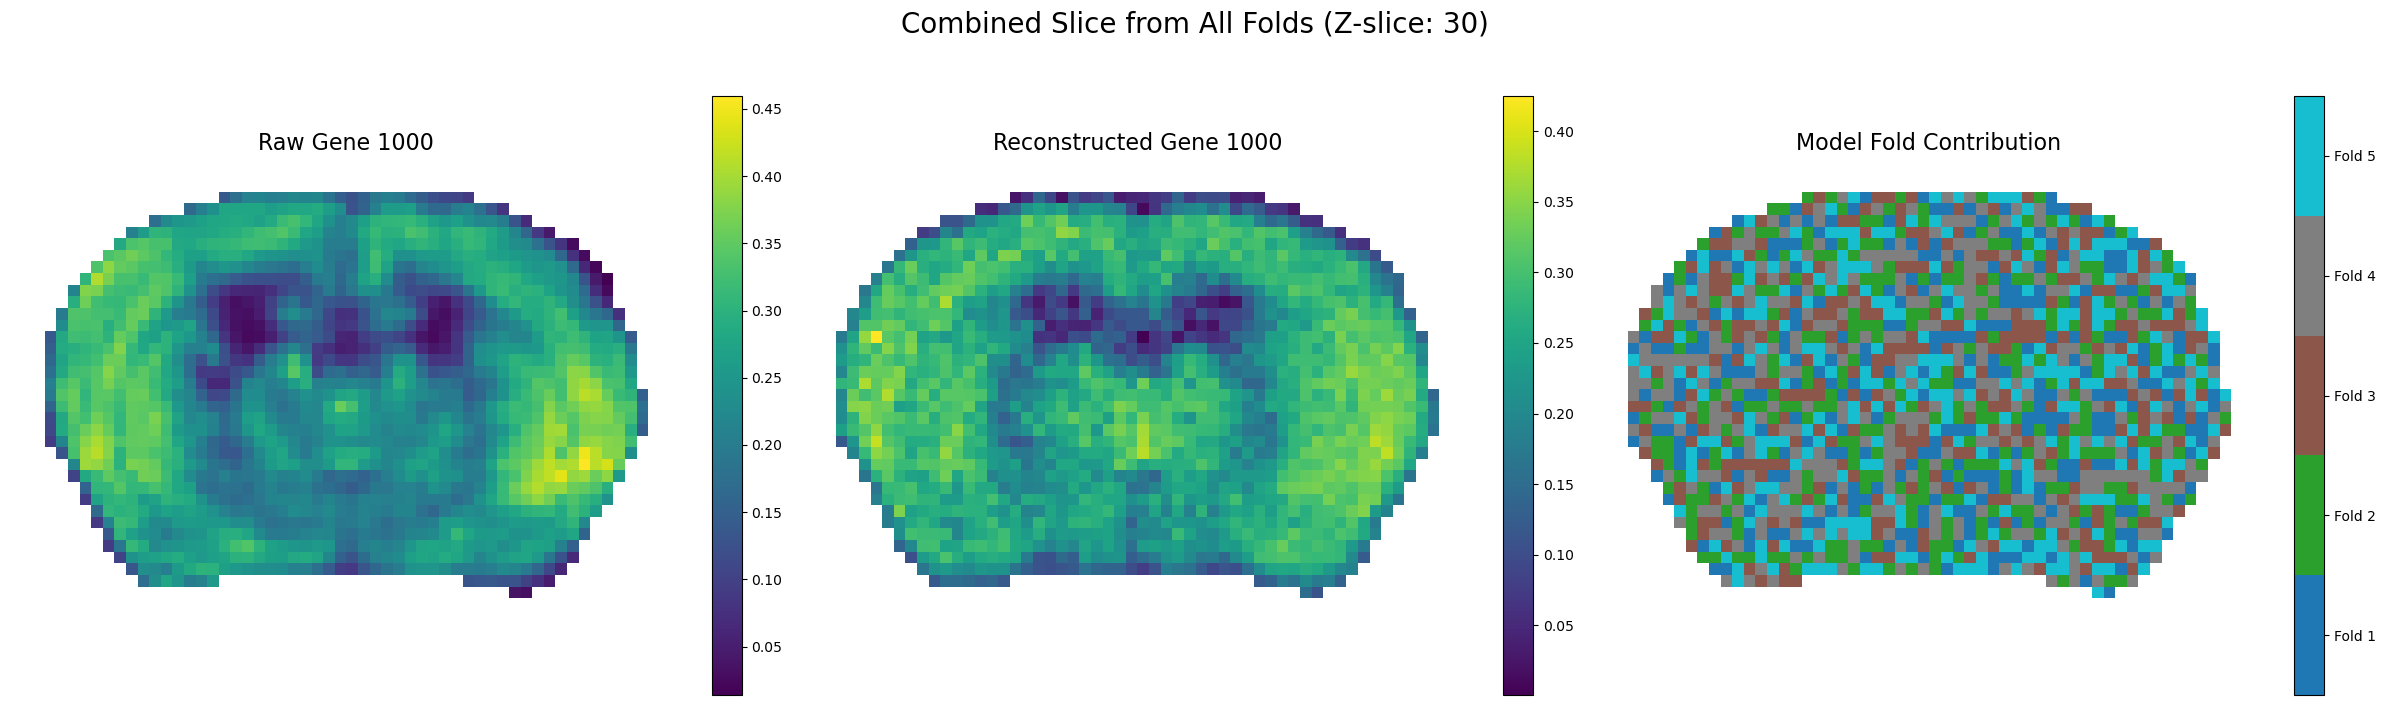

In [65]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- Initialization of Combined Maps ---
shape = (data_zscored.shape[1], data_zscored.shape[2], data_zscored.shape[3])
_, y_dim, x_dim = shape
n_genes = data_zscored.shape[0]
gene_to_plot = 1000
z_slice_to_plot = 30

# Initialize maps that will be populated by all folds
full_raw_map = np.full((y_dim, x_dim), np.nan)
full_recon_map = np.full((y_dim, x_dim), np.nan)
fold_contribution_map = np.full((y_dim, x_dim), np.nan) # Map to store fold index

# --- Main Loop to Populate Combined Maps ---
num_folds = len(folds)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold_idx in range(num_folds):
    print(f"Processing Fold {fold_idx + 1}/{num_folds}...")
    
    # Load model for the current fold
    model = PathwayVAE_cls_reg(
        num_genes=n_genes,
        latent_dim=200,
        shape=shape
    ).to(device)
    model_path = f"pathway_vae_fold{fold_idx}.pt"
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # Get the test dataloader for the current fold
    test_dict = folds[fold_idx][2]
    test_dl = make_dataloader_collapsed(test_dict, n_genes, shape, batch_size=512, shuffle=False)
    
    # Process data and populate the full maps
    with torch.no_grad():
        for x, z, y, x_pos in test_dl:
            x, z, y, x_pos = x.to(device), z.to(device), y.to(device), x_pos.to(device)
            
            recon, _, _, _, _, _, _, _, _ = model(x)

            # Move tensors to CPU and convert to numpy
            recon_np = recon.cpu().numpy()
            x_np = x.cpu().numpy()
            z_np = z.cpu().numpy()
            y_np = y.cpu().numpy()
            x_pos_np = x_pos.cpu().numpy()

            # Filter for the desired z-slice and populate maps
            for i in range(len(z_np)):
                if z_np[i] == z_slice_to_plot:
                    yy, xx = y_np[i], x_pos_np[i]
                    if 0 <= yy < y_dim and 0 <= xx < x_dim:
                        full_raw_map[yy, xx] = x_np[i, gene_to_plot]
                        full_recon_map[yy, xx] = recon_np[i, gene_to_plot]
                        fold_contribution_map[yy, xx] = fold_idx

# --- Plotting the Combined Slice ---
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle(f"Combined Slice from All Folds (Z-slice: {z_slice_to_plot})", fontsize=20, y=1.0)

# Plot Raw Gene Expression
im1 = axes[0].imshow(full_raw_map, cmap='viridis')
axes[0].set_title(f"Raw Gene {gene_to_plot}", fontsize=16)
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

# Plot Reconstructed Gene Expression
im2 = axes[1].imshow(full_recon_map, cmap='viridis')
axes[1].set_title(f"Reconstructed Gene {gene_to_plot}", fontsize=16)
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

# Plot Fold Contribution
# Use a qualitative colormap like 'tab10' for distinct colors per fold
cmap = plt.get_cmap('tab10', num_folds)
im3 = axes[2].imshow(fold_contribution_map, cmap=cmap, vmin=-0.5, vmax=num_folds - 0.5)
axes[2].set_title("Model Fold Contribution", fontsize=16)
axes[2].axis('off')
cbar = fig.colorbar(im3, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04, ticks=np.arange(num_folds))
cbar.set_ticklabels([f'Fold {i+1}' for i in range(num_folds)])


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


PathwayVAE_cls_reg(
  (act): LeakyReLU(negative_slope=0.01)
  (encoder): Sequential(
    (0): Linear(in_features=3000, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.7, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
  )
  (fc_mu): Linear(in_features=500, out_features=200, bias=True)
  (fc_logvar): Linear(in_features=500, out_features=200, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=200, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=3000, bias=True)
  )
  (cls_z): Sequential(
    (0): Linear(in_features=200, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negati

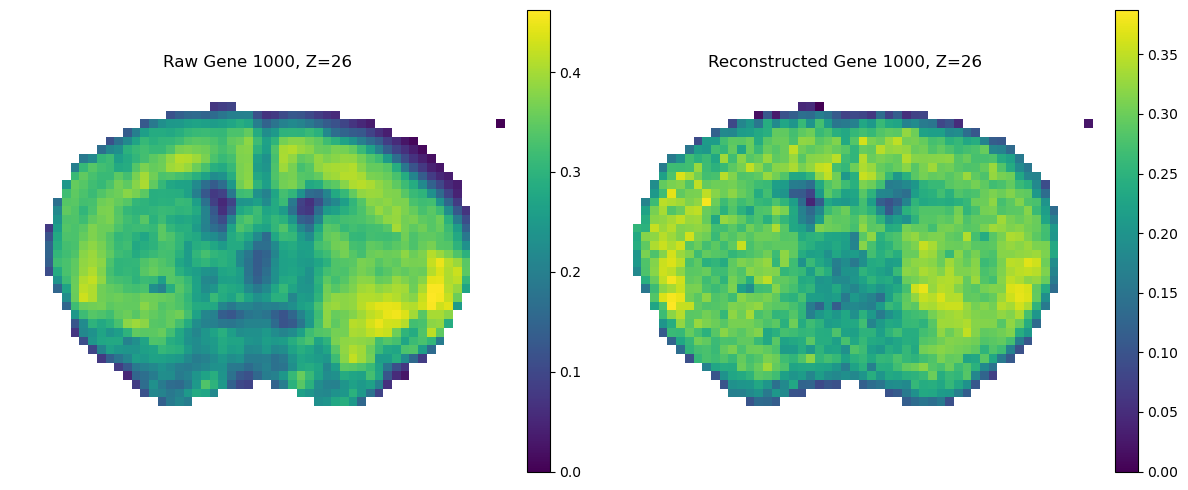

In [53]:
# Combine all keys from train, val, and test dicts for fold 1
shape = (67, 41, 58)
full_dict = {}
full_dict.update(train_dict)
full_dict.update(val_dict)
full_dict.update(test_dict)

# Create the full dataloader
full_dl = make_dataloader_collapsed(full_dict, n_genes,shape, batch_size=128, shuffle=False)
model.load_state_dict(torch.load("pathway_vae_fold0.pt"))
print(model)
plot_full_slice(model, full_dl, device, gene_index=1000, z_slice=26)

Top 5 important genes across all folds: ['LOC434002', 'Elmod1', 'Snhg7', 'App', 'Flcn']

--- Plotting for Gene: LOC434002 (Index: 58) ---


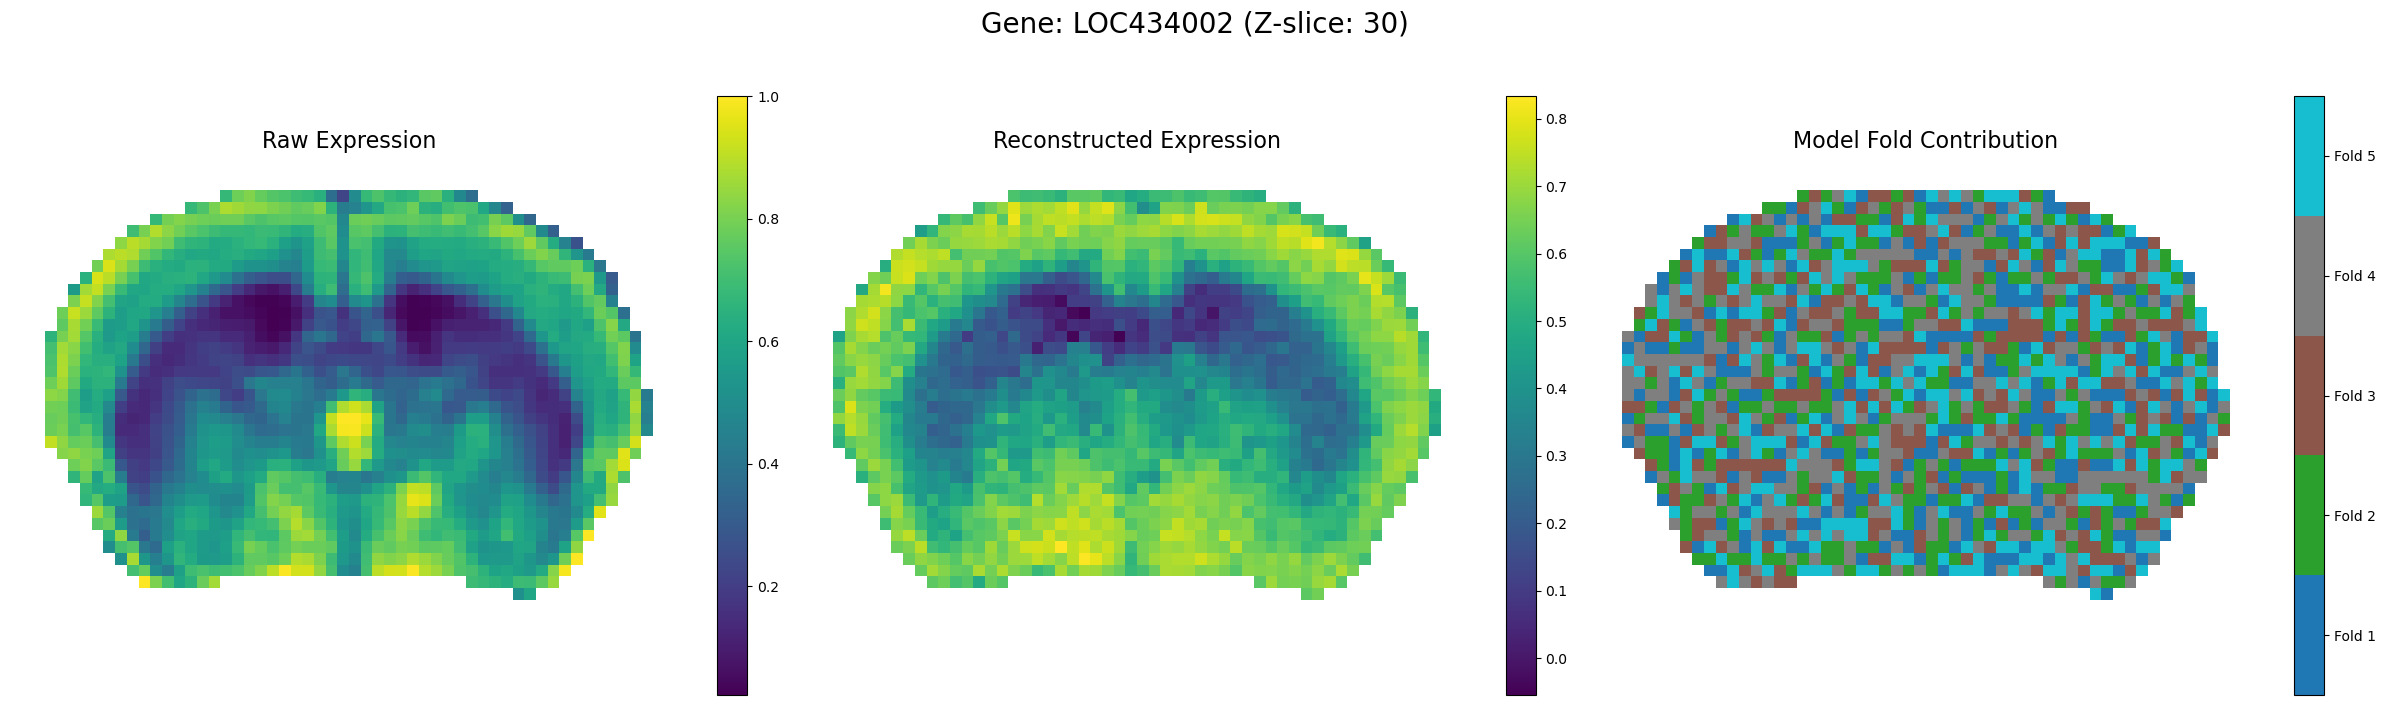


--- Plotting for Gene: Elmod1 (Index: 95) ---


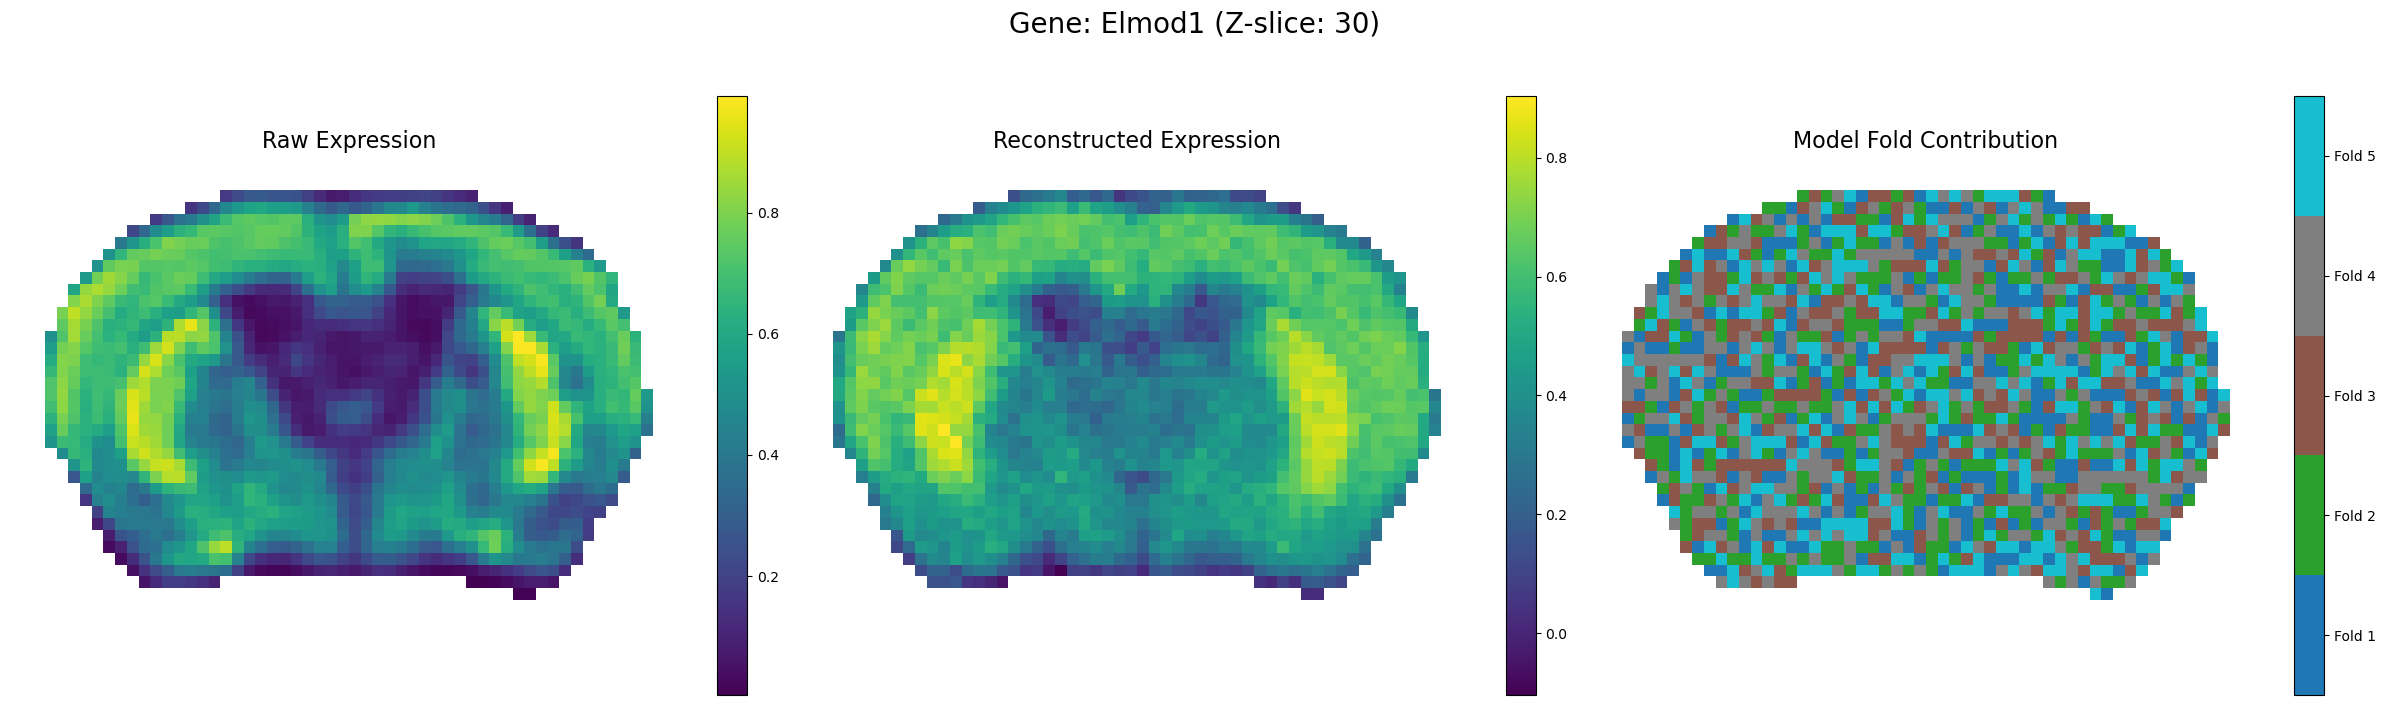


--- Plotting for Gene: Snhg7 (Index: 19) ---


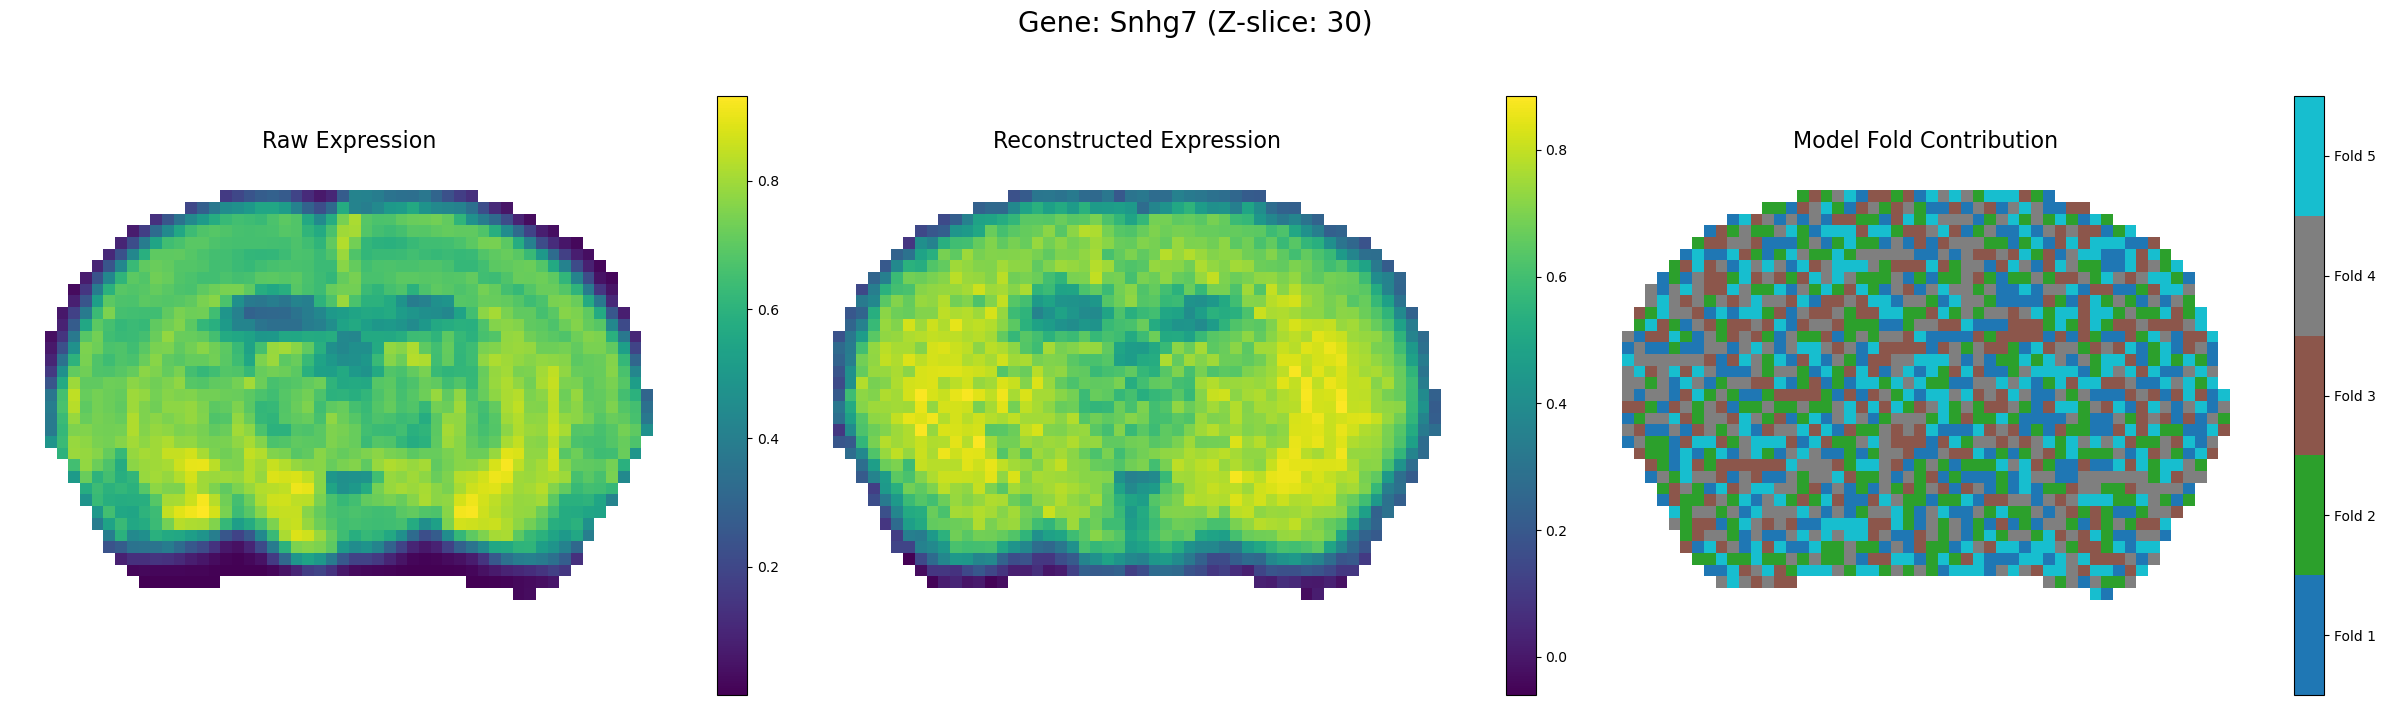


--- Plotting for Gene: App (Index: 6) ---


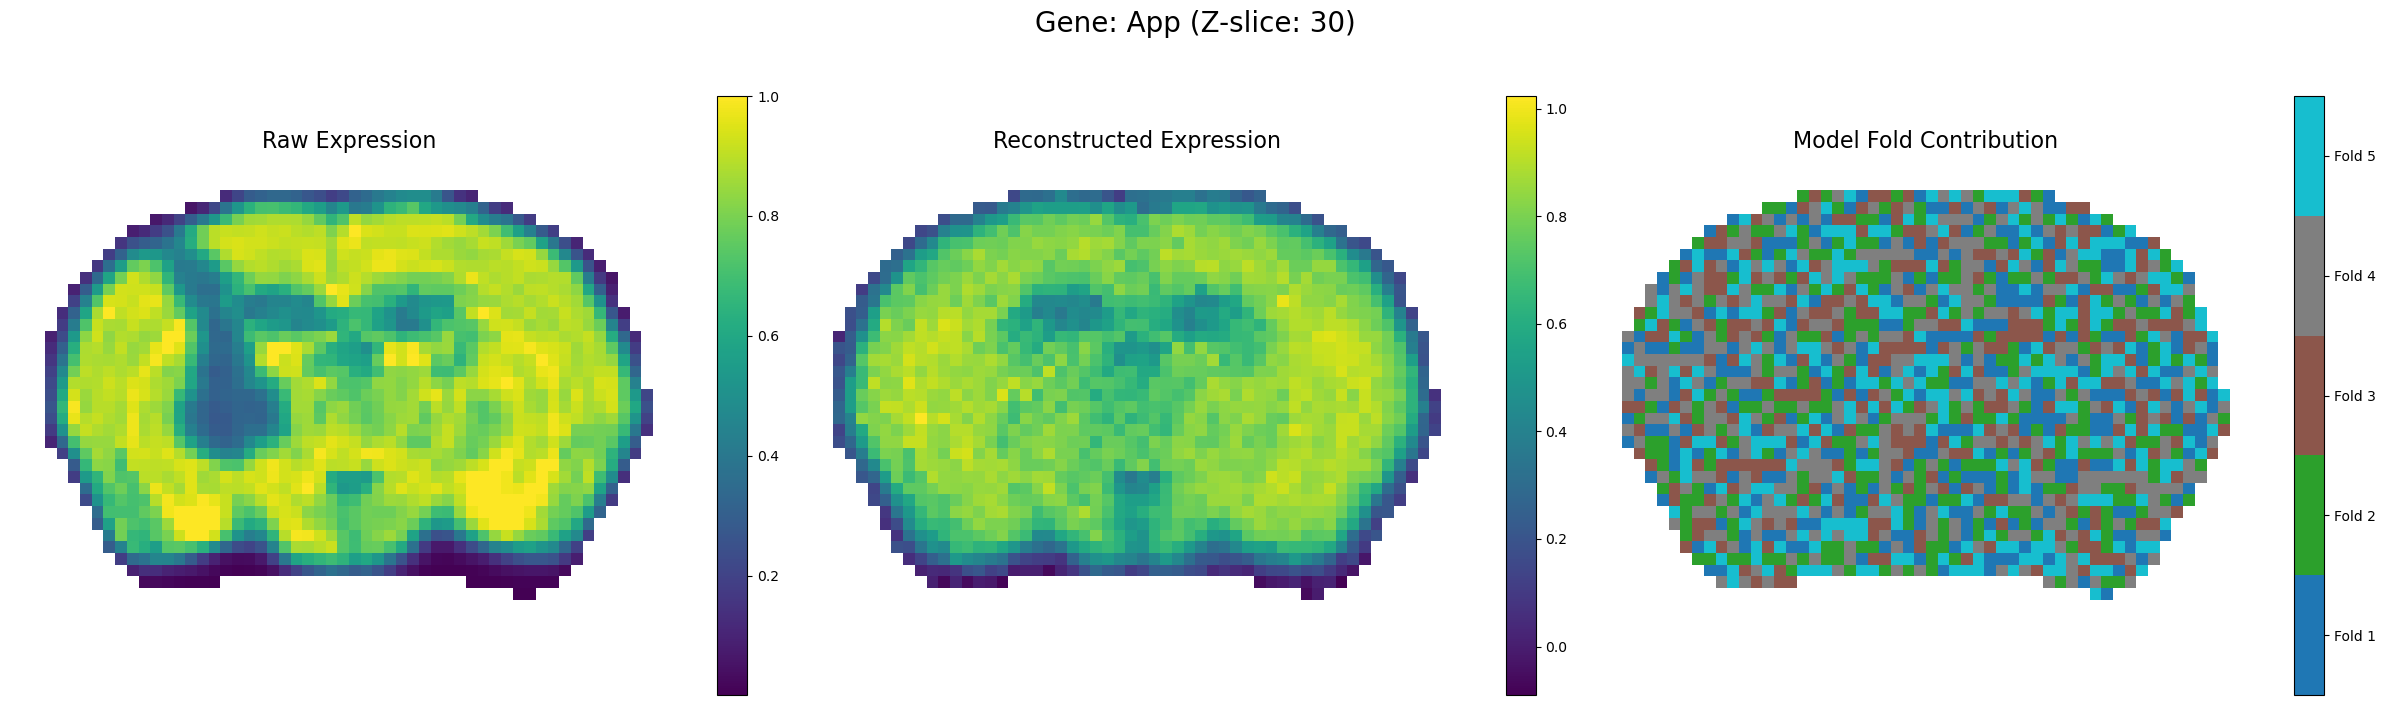


--- Plotting for Gene: Flcn (Index: 4) ---


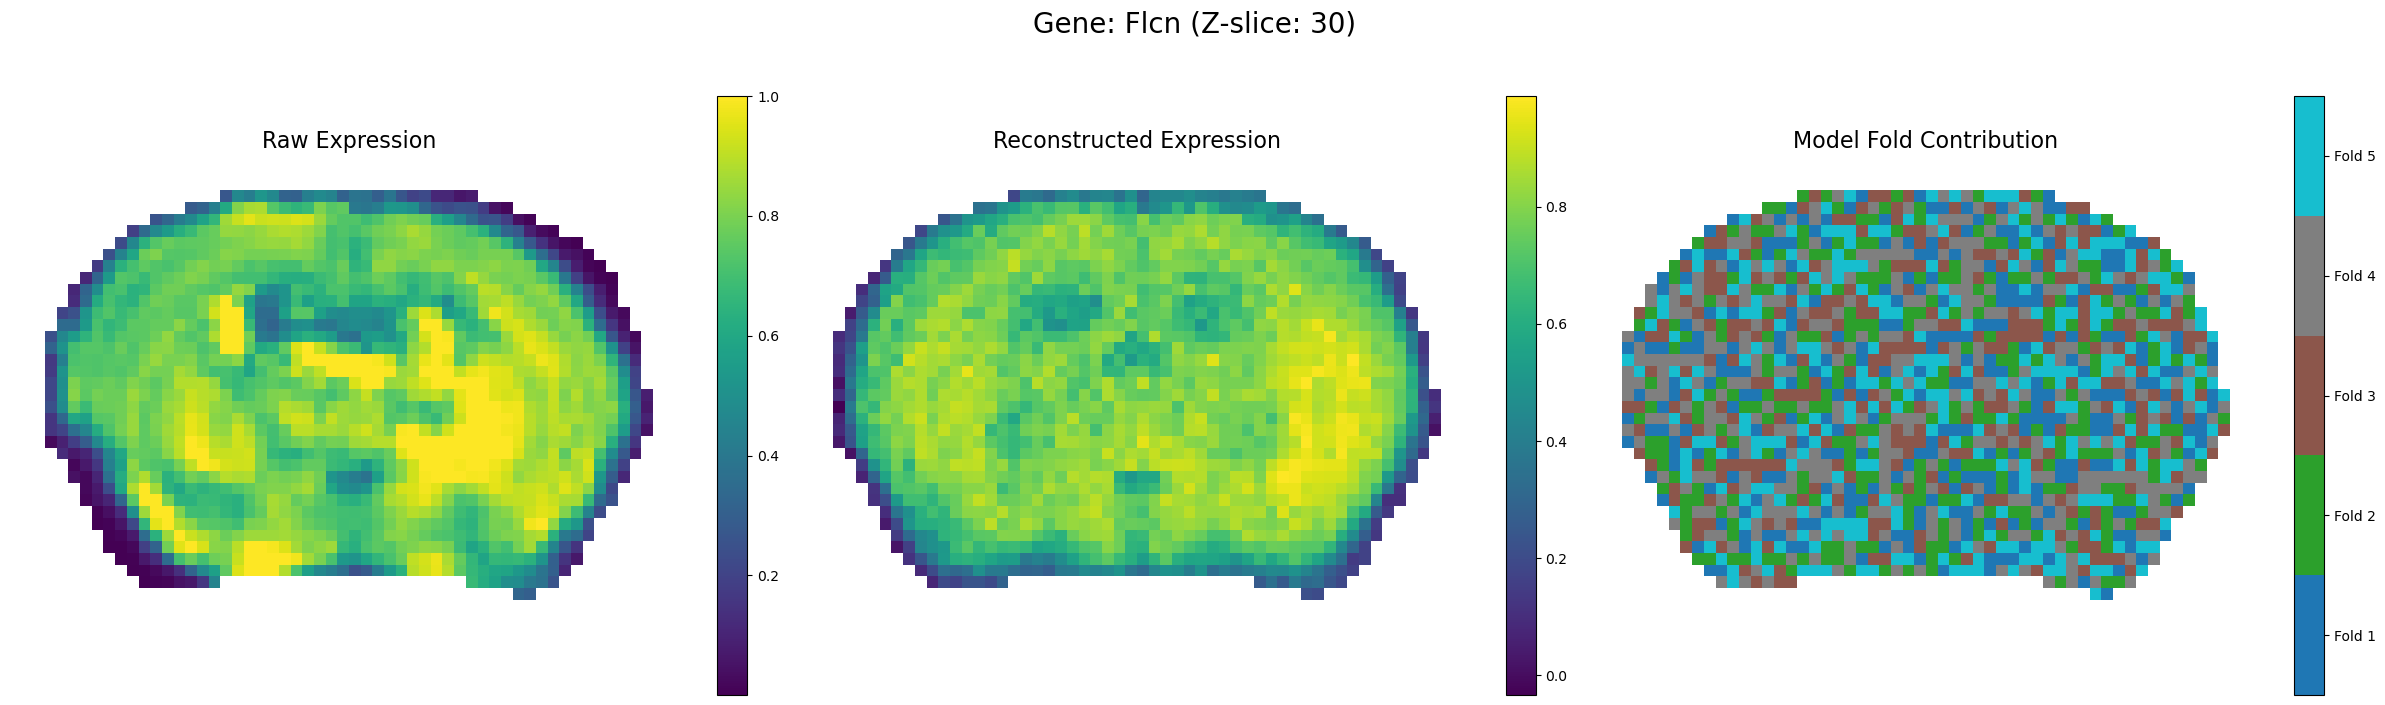

In [67]:
# --- 1. Aggregate Gene Importance Across All Folds ---
num_folds = len(folds)
n_genes = data_zscored.shape[0]
shape = (data_zscored.shape[1], data_zscored.shape[2], data_zscored.shape[3])
all_gene_importances = np.zeros((num_folds, n_genes))

for fold_idx in range(num_folds):
    # Load model for the current fold
    model = PathwayVAE_cls_reg(num_genes=n_genes, latent_dim=200, shape=shape).to(device)
    model_path = f"pathway_vae_fold{fold_idx}.pt"
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Get decoder weights and calculate importance
    with torch.no_grad():
        # Shape of weights is (n_genes, 500). We want one importance value per gene.
        weights = model.decoder[1].weight.abs().cpu().numpy()
        gene_importance = weights.mean(axis=1)
        all_gene_importances[fold_idx] = gene_importance

# Calculate mean importance across folds and get top genes
mean_importance = all_gene_importances.mean(axis=0)
top_indices = np.argsort(mean_importance)[-5:][::-1]
top_genes_names = [gene_names[i] for i in top_indices]

print("Top 5 important genes across all folds:", top_genes_names)


# --- 2. Plot Reconstructions for Each Top Gene ---
z_slice_to_plot = 30

for gene_to_plot, gene_name in zip(top_indices, top_genes_names):
    print(f"\n--- Plotting for Gene: {gene_name} (Index: {gene_to_plot}) ---")
    
    # Initialize maps for the current gene
    y_dim, x_dim = shape[1], shape[2]
    full_raw_map = np.full((y_dim, x_dim), np.nan)
    full_recon_map = np.full((y_dim, x_dim), np.nan)
    fold_contribution_map = np.full((y_dim, x_dim), np.nan)

    # Loop through folds to populate the maps from each test set
    for fold_idx in range(num_folds):
        # Load model
        model = PathwayVAE_cls_reg(num_genes=n_genes, latent_dim=200, shape=shape).to(device)
        model_path = f"pathway_vae_fold{fold_idx}.pt"
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        
        # Get the test dataloader for the current fold
        test_dict = folds[fold_idx][2]
        test_dl = make_dataloader_collapsed(test_dict, n_genes, shape, batch_size=512, shuffle=False)
        
        # Process data and populate the maps
        with torch.no_grad():
            for x, z, y, x_pos in test_dl:
                x, z, y, x_pos = x.to(device), z.to(device), y.to(device), x_pos.to(device)
                recon, *_ = model(x)

                recon_np, x_np = recon.cpu().numpy(), x.cpu().numpy()
                z_np, y_np, x_pos_np = z.cpu().numpy(), y.cpu().numpy(), x_pos.cpu().numpy()

                # Filter for the desired z-slice
                mask = z_np == z_slice_to_plot
                if np.any(mask):
                    yy, xx = y_np[mask], x_pos_np[mask]
                    full_raw_map[yy, xx] = x_np[mask, gene_to_plot]
                    full_recon_map[yy, xx] = recon_np[mask, gene_to_plot]
                    fold_contribution_map[yy, xx] = fold_idx

    # Plotting the combined slice for the current gene
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    fig.suptitle(f"Gene: {gene_name} (Z-slice: {z_slice_to_plot})", fontsize=20, y=1.0)

    im1 = axes[0].imshow(full_raw_map, cmap='viridis')
    axes[0].set_title(f"Raw Expression", fontsize=16)
    axes[0].axis('off')
    fig.colorbar(im1, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

    im2 = axes[1].imshow(full_recon_map, cmap='viridis')
    axes[1].set_title(f"Reconstructed Expression", fontsize=16)
    axes[1].axis('off')
    fig.colorbar(im2, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

    cmap = plt.get_cmap('tab10', num_folds)
    im3 = axes[2].imshow(fold_contribution_map, cmap=cmap, vmin=-0.5, vmax=num_folds - 0.5)
    axes[2].set_title("Model Fold Contribution", fontsize=16)
    axes[2].axis('off')
    cbar = fig.colorbar(im3, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04, ticks=np.arange(num_folds))
    cbar.set_ticklabels([f'Fold {i+1}' for i in range(num_folds)])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

--- Evaluating Fold 1/5 ---
X → R²: 0.9864, RMSE: 1.4783
Y → R²: 0.9855, RMSE: 1.0307
Z → R²: 0.9789, RMSE: 1.6076


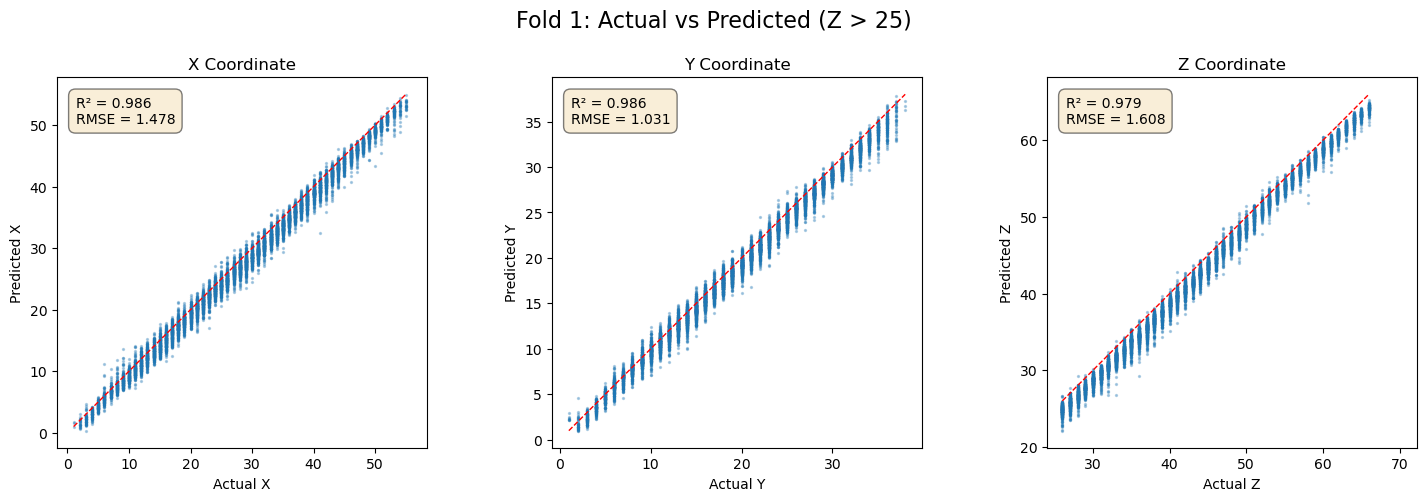

------------------------------

--- Evaluating Fold 2/5 ---
X → R²: 0.9867, RMSE: 1.4662
Y → R²: 0.9826, RMSE: 1.1391
Z → R²: 0.9717, RMSE: 1.8454


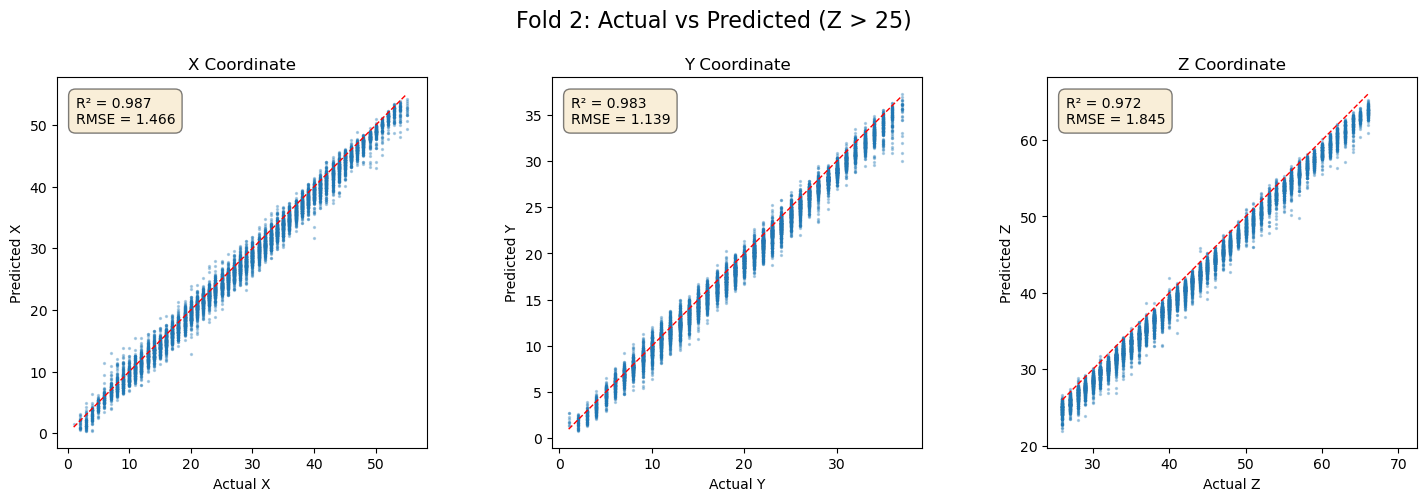

------------------------------

--- Evaluating Fold 3/5 ---
X → R²: 0.9864, RMSE: 1.4782
Y → R²: 0.9811, RMSE: 1.1815
Z → R²: 0.9778, RMSE: 1.6359


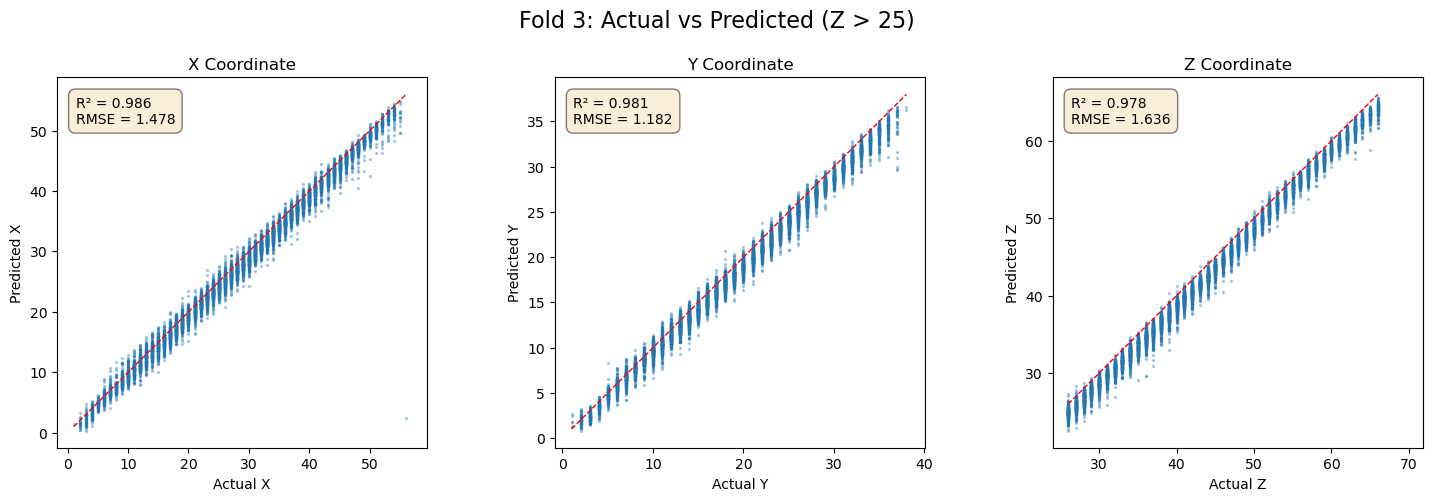

------------------------------

--- Evaluating Fold 4/5 ---
X → R²: 0.9813, RMSE: 1.7186
Y → R²: 0.9793, RMSE: 1.2410
Z → R²: 0.9759, RMSE: 1.7290


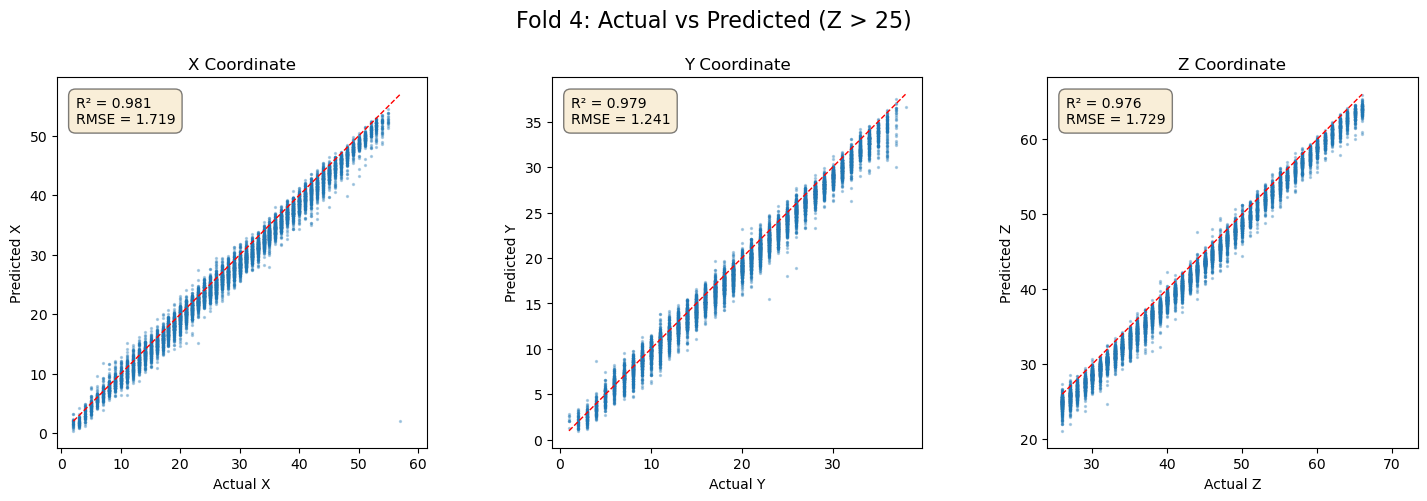

------------------------------

--- Evaluating Fold 5/5 ---
X → R²: 0.9849, RMSE: 1.5580
Y → R²: 0.9824, RMSE: 1.1516
Z → R²: 0.9717, RMSE: 1.8715


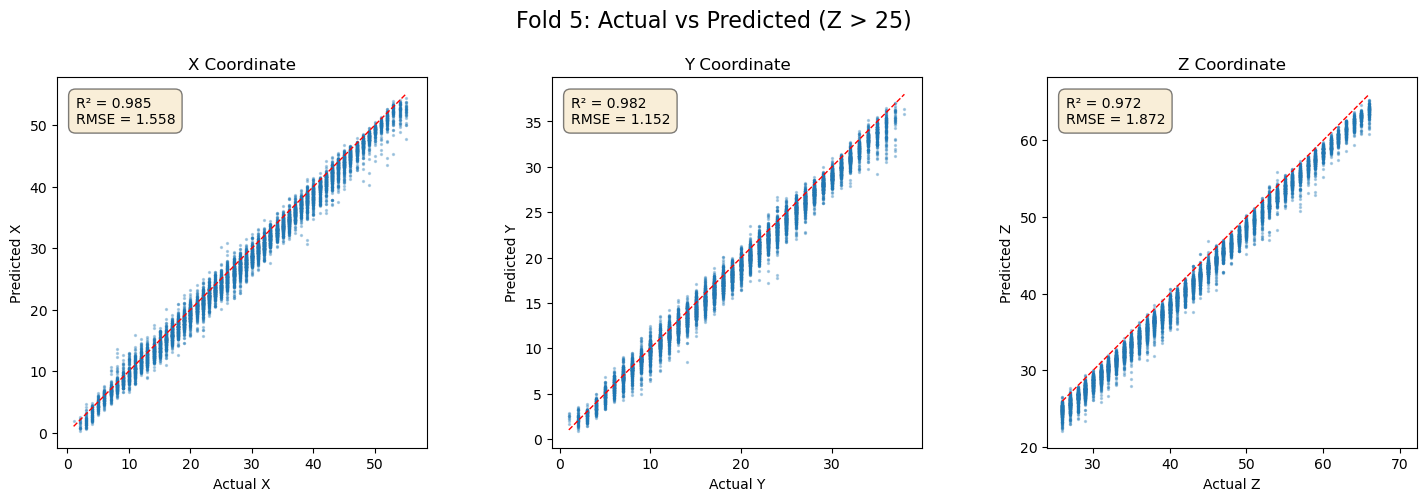

------------------------------



In [69]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# volume dims
Z_dim, Y_dim, X_dim = shape
num_folds = len(folds)

for fold_idx in range(num_folds):
  print(f"--- Evaluating Fold {fold_idx+1}/{num_folds} ---")

  # Load model for the current fold
  model = PathwayVAE_cls_reg(num_genes=n_genes, latent_dim=200, shape=shape).to(device)
  model_path = f"pathway_vae_fold{fold_idx}.pt"
  model.load_state_dict(torch.load(model_path, map_location=device))
  model.eval()

  # Create dataloader for the test set of the current fold
  test_dl = make_dataloader_collapsed(folds[fold_idx][2], n_genes, shape, batch_size=128, shuffle=False)

  actual_x, pred_x = [], []
  actual_y, pred_y = [], []
  actual_z, pred_z = [], []

  with torch.no_grad():
    for x_batch, z_batch, y_batch, x_pos_batch in test_dl:
      x_batch = x_batch.to(device)
      # unpack everything
      recon, mu, logvar, z_logits, y_logits, x_logits, \
        x_reg, y_reg, z_reg = model(x_batch)

      # pull to CPU
      x_reg = x_reg.squeeze().cpu().numpy()
      y_reg = y_reg.squeeze().cpu().numpy()
      z_reg = z_reg.squeeze().cpu().numpy()

      # true positions
      tx = x_pos_batch.numpy()
      ty = y_batch.numpy()
      tz = z_batch.numpy()

      # Filter for z > 25
      mask = tz > 25

      actual_x.extend(tx[mask])
      pred_x.extend(x_reg[mask])
      actual_y.extend(ty[mask])
      pred_y.extend(y_reg[mask])
      actual_z.extend(tz[mask])
      pred_z.extend(z_reg[mask])

  # Compute R² and RMSE
  if len(actual_x) > 0:
    r2_x = r2_score(actual_x, pred_x)
    rmse_x = np.sqrt(mean_squared_error(actual_x, pred_x))
    print(f"X → R²: {r2_x:.4f}, RMSE: {rmse_x:.4f}")

    r2_y = r2_score(actual_y, pred_y)
    rmse_y = np.sqrt(mean_squared_error(actual_y, pred_y))
    print(f"Y → R²: {r2_y:.4f}, RMSE: {rmse_y:.4f}")

    r2_z = r2_score(actual_z, pred_z)
    rmse_z = np.sqrt(mean_squared_error(actual_z, pred_z))
    print(f"Z → R²: {r2_z:.4f}, RMSE: {rmse_z:.4f}")

    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Fold {fold_idx+1}: Actual vs Predicted (Z > 25)', fontsize=16)

    # Scatter X
    axes[0].scatter(actual_x, pred_x, s=2, alpha=0.3)
    axes[0].plot([min(actual_x), max(actual_x)],[min(actual_x), max(actual_x)],'r--', linewidth=1)
    axes[0].set_xlabel("Actual X")
    axes[0].set_ylabel("Predicted X")
    axes[0].set_title("X Coordinate")
    axes[0].axis('square')
    stats_text_x = f'R² = {r2_x:.3f}\nRMSE = {rmse_x:.3f}'
    axes[0].text(0.05, 0.95, stats_text_x, transform=axes[0].transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

    # Scatter Y
    axes[1].scatter(actual_y, pred_y, s=2, alpha=0.3)
    axes[1].plot([min(actual_y), max(actual_y)],[min(actual_y), max(actual_y)],'r--', linewidth=1)
    axes[1].set_xlabel("Actual Y")
    axes[1].set_ylabel("Predicted Y")
    axes[1].set_title("Y Coordinate")
    axes[1].axis('square')
    stats_text_y = f'R² = {r2_y:.3f}\nRMSE = {rmse_y:.3f}'
    axes[1].text(0.05, 0.95, stats_text_y, transform=axes[1].transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

    # Scatter Z
    axes[2].scatter(actual_z, pred_z, s=2, alpha=0.3)
    axes[2].plot([min(actual_z), max(actual_z)],[min(actual_z), max(actual_z)],'r--', linewidth=1)
    axes[2].set_xlabel("Actual Z")
    axes[2].set_ylabel("Predicted Z")
    axes[2].set_title("Z Coordinate")
    axes[2].axis('square')
    stats_text_z = f'R² = {r2_z:.3f}\nRMSE = {rmse_z:.3f}'
    axes[2].text(0.05, 0.95, stats_text_z, transform=axes[2].transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
  else:
    print("No data found for Z > 25.")
  print("-" * 30 + "\n")



--- Evaluating Fold 1/5 ---


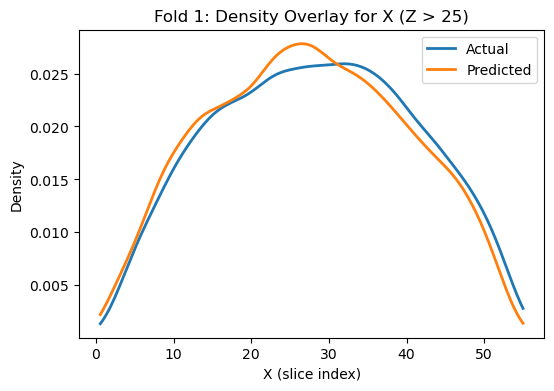

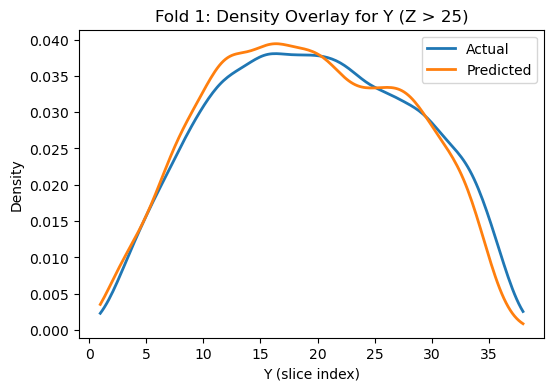

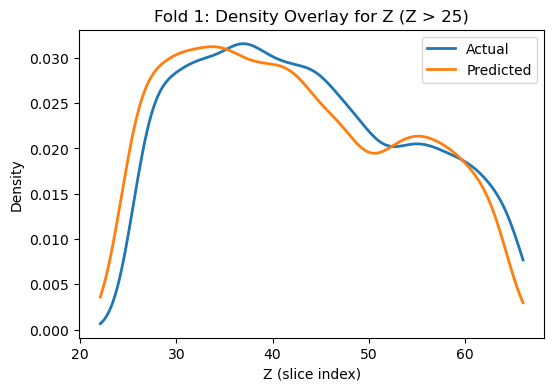


--- Evaluating Fold 2/5 ---


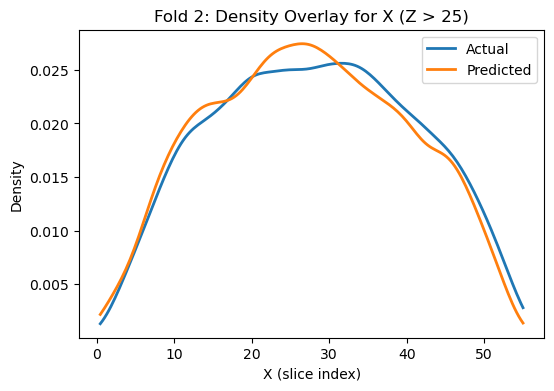

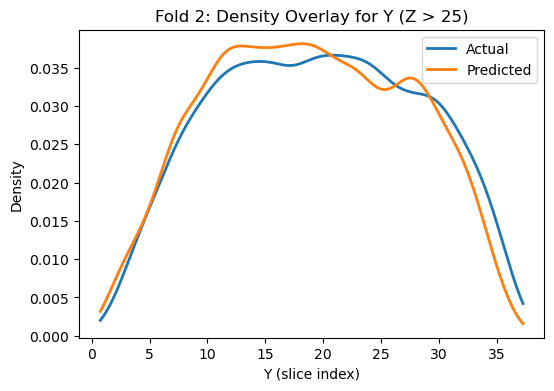

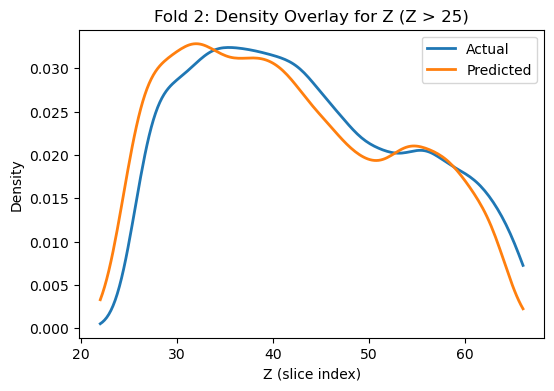


--- Evaluating Fold 3/5 ---


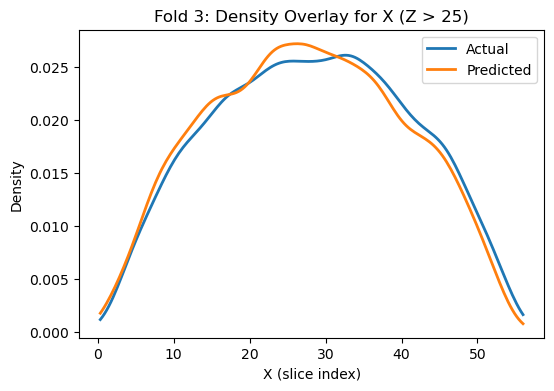

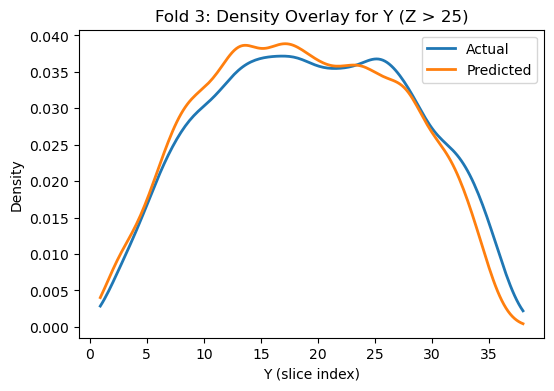

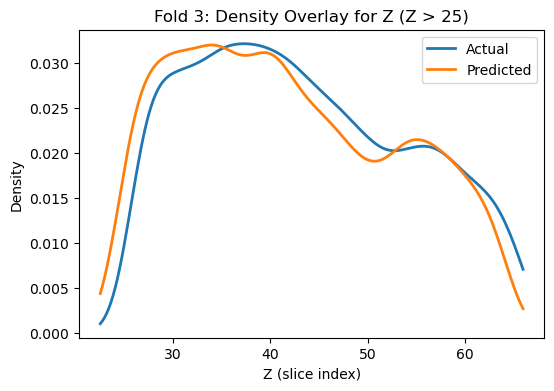


--- Evaluating Fold 4/5 ---


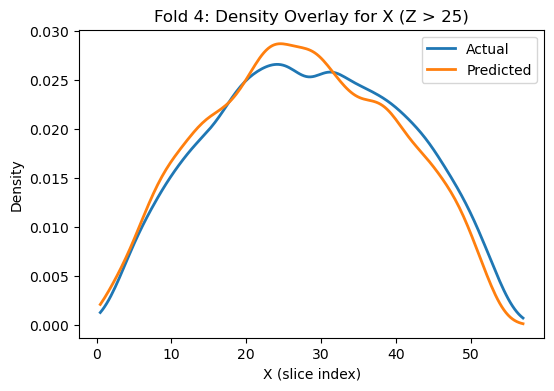

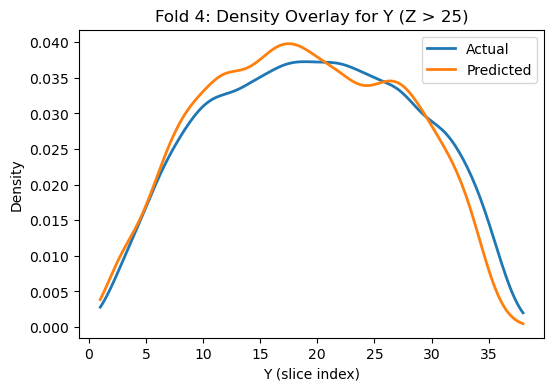

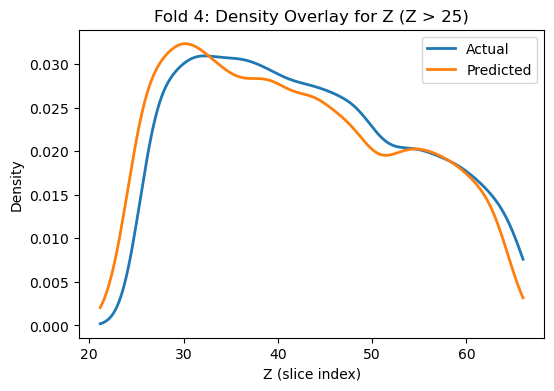


--- Evaluating Fold 5/5 ---


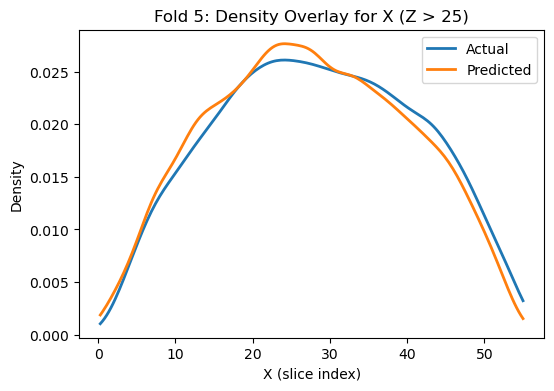

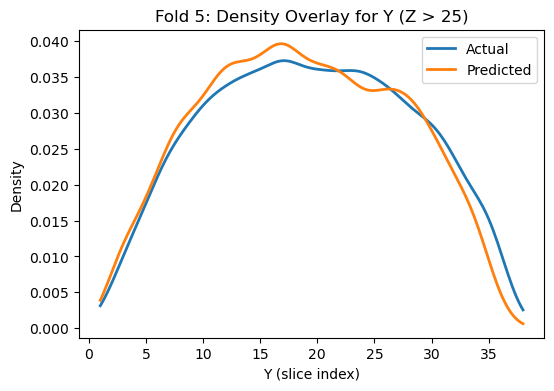

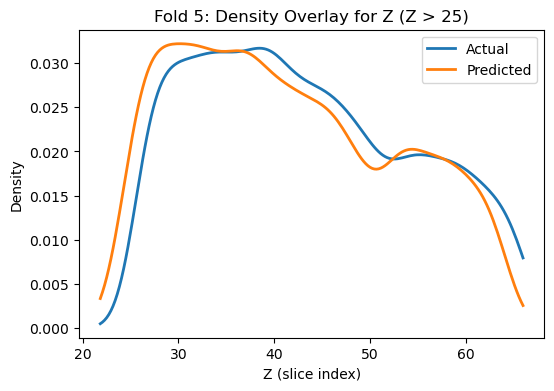

In [70]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np

def plot_overlay_density(actual, predicted, coord_name, fold_idx):
    if len(actual) == 0 or len(predicted) == 0:
        print(f"Not enough data to plot for {coord_name}")
        return
    kde_actual = gaussian_kde(actual)
    kde_pred   = gaussian_kde(predicted)
    xs = np.linspace(min(actual.min(), predicted.min()), max(actual.max(), predicted.max()), 200)
    plt.figure(figsize=(6,4))
    plt.plot(xs, kde_actual(xs), label='Actual', lw=2)
    plt.plot(xs, kde_pred(xs),   label='Predicted', lw=2)
    plt.xlabel(f'{coord_name} (slice index)')
    plt.ylabel('Density')
    plt.title(f'Fold {fold_idx+1}: Density Overlay for {coord_name} (Z > 25)')
    plt.legend()
    plt.show()

num_folds = len(folds)
shape = (data_zscored.shape[1], data_zscored.shape[2], data_zscored.shape[3])
n_genes = data_zscored.shape[0]

for fold_idx in range(num_folds):
    print(f"\n--- Evaluating Fold {fold_idx + 1}/{num_folds} ---")

    # Load model for the current fold
    model = PathwayVAE_cls_reg(num_genes=n_genes, latent_dim=200, shape=shape).to(device)
    model_path = f"pathway_vae_fold{fold_idx}.pt"
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Create dataloader for the test set of the current fold
    test_dl = make_dataloader_collapsed(folds[fold_idx][2], n_genes, shape, batch_size=512, shuffle=False)

    # Re-collect actual vs predicted from the current fold's test_dl
    actual_x, pred_x = [], []
    actual_y, pred_y = [], []
    actual_z, pred_z = [], []

    with torch.no_grad():
        for x_batch, z_batch, y_batch, x_pos_batch in test_dl:
            x_batch = x_batch.to(device)
            # unpack all outputs
            *_, x_reg, y_reg, z_reg = model(x_batch)
            tx = x_pos_batch.numpy()
            ty = y_batch.numpy()
            tz = z_batch.numpy()
            px = x_reg.squeeze().cpu().numpy()
            py = y_reg.squeeze().cpu().numpy()
            pz = z_reg.squeeze().cpu().numpy()
            
            # Filter for z > 25
            mask = tz > 25
            
            actual_x.extend(tx[mask])
            pred_x.extend(px[mask])
            actual_y.extend(ty[mask])
            pred_y.extend(py[mask])
            actual_z.extend(tz[mask])
            pred_z.extend(pz[mask])

    actual_x = np.array(actual_x)
    pred_x   = np.array(pred_x)
    actual_y = np.array(actual_y)
    pred_y   = np.array(pred_y)
    actual_z = np.array(actual_z)
    pred_z   = np.array(pred_z)

    # Plot overlay densities for the current fold
    plot_overlay_density(actual_x, pred_x, 'X', fold_idx)
    plot_overlay_density(actual_y, pred_y, 'Y', fold_idx)
    plot_overlay_density(actual_z, pred_z, 'Z', fold_idx)

--- Processing Fold 1/5 ---
--- Processing Fold 2/5 ---
--- Processing Fold 3/5 ---
--- Processing Fold 4/5 ---
--- Processing Fold 5/5 ---


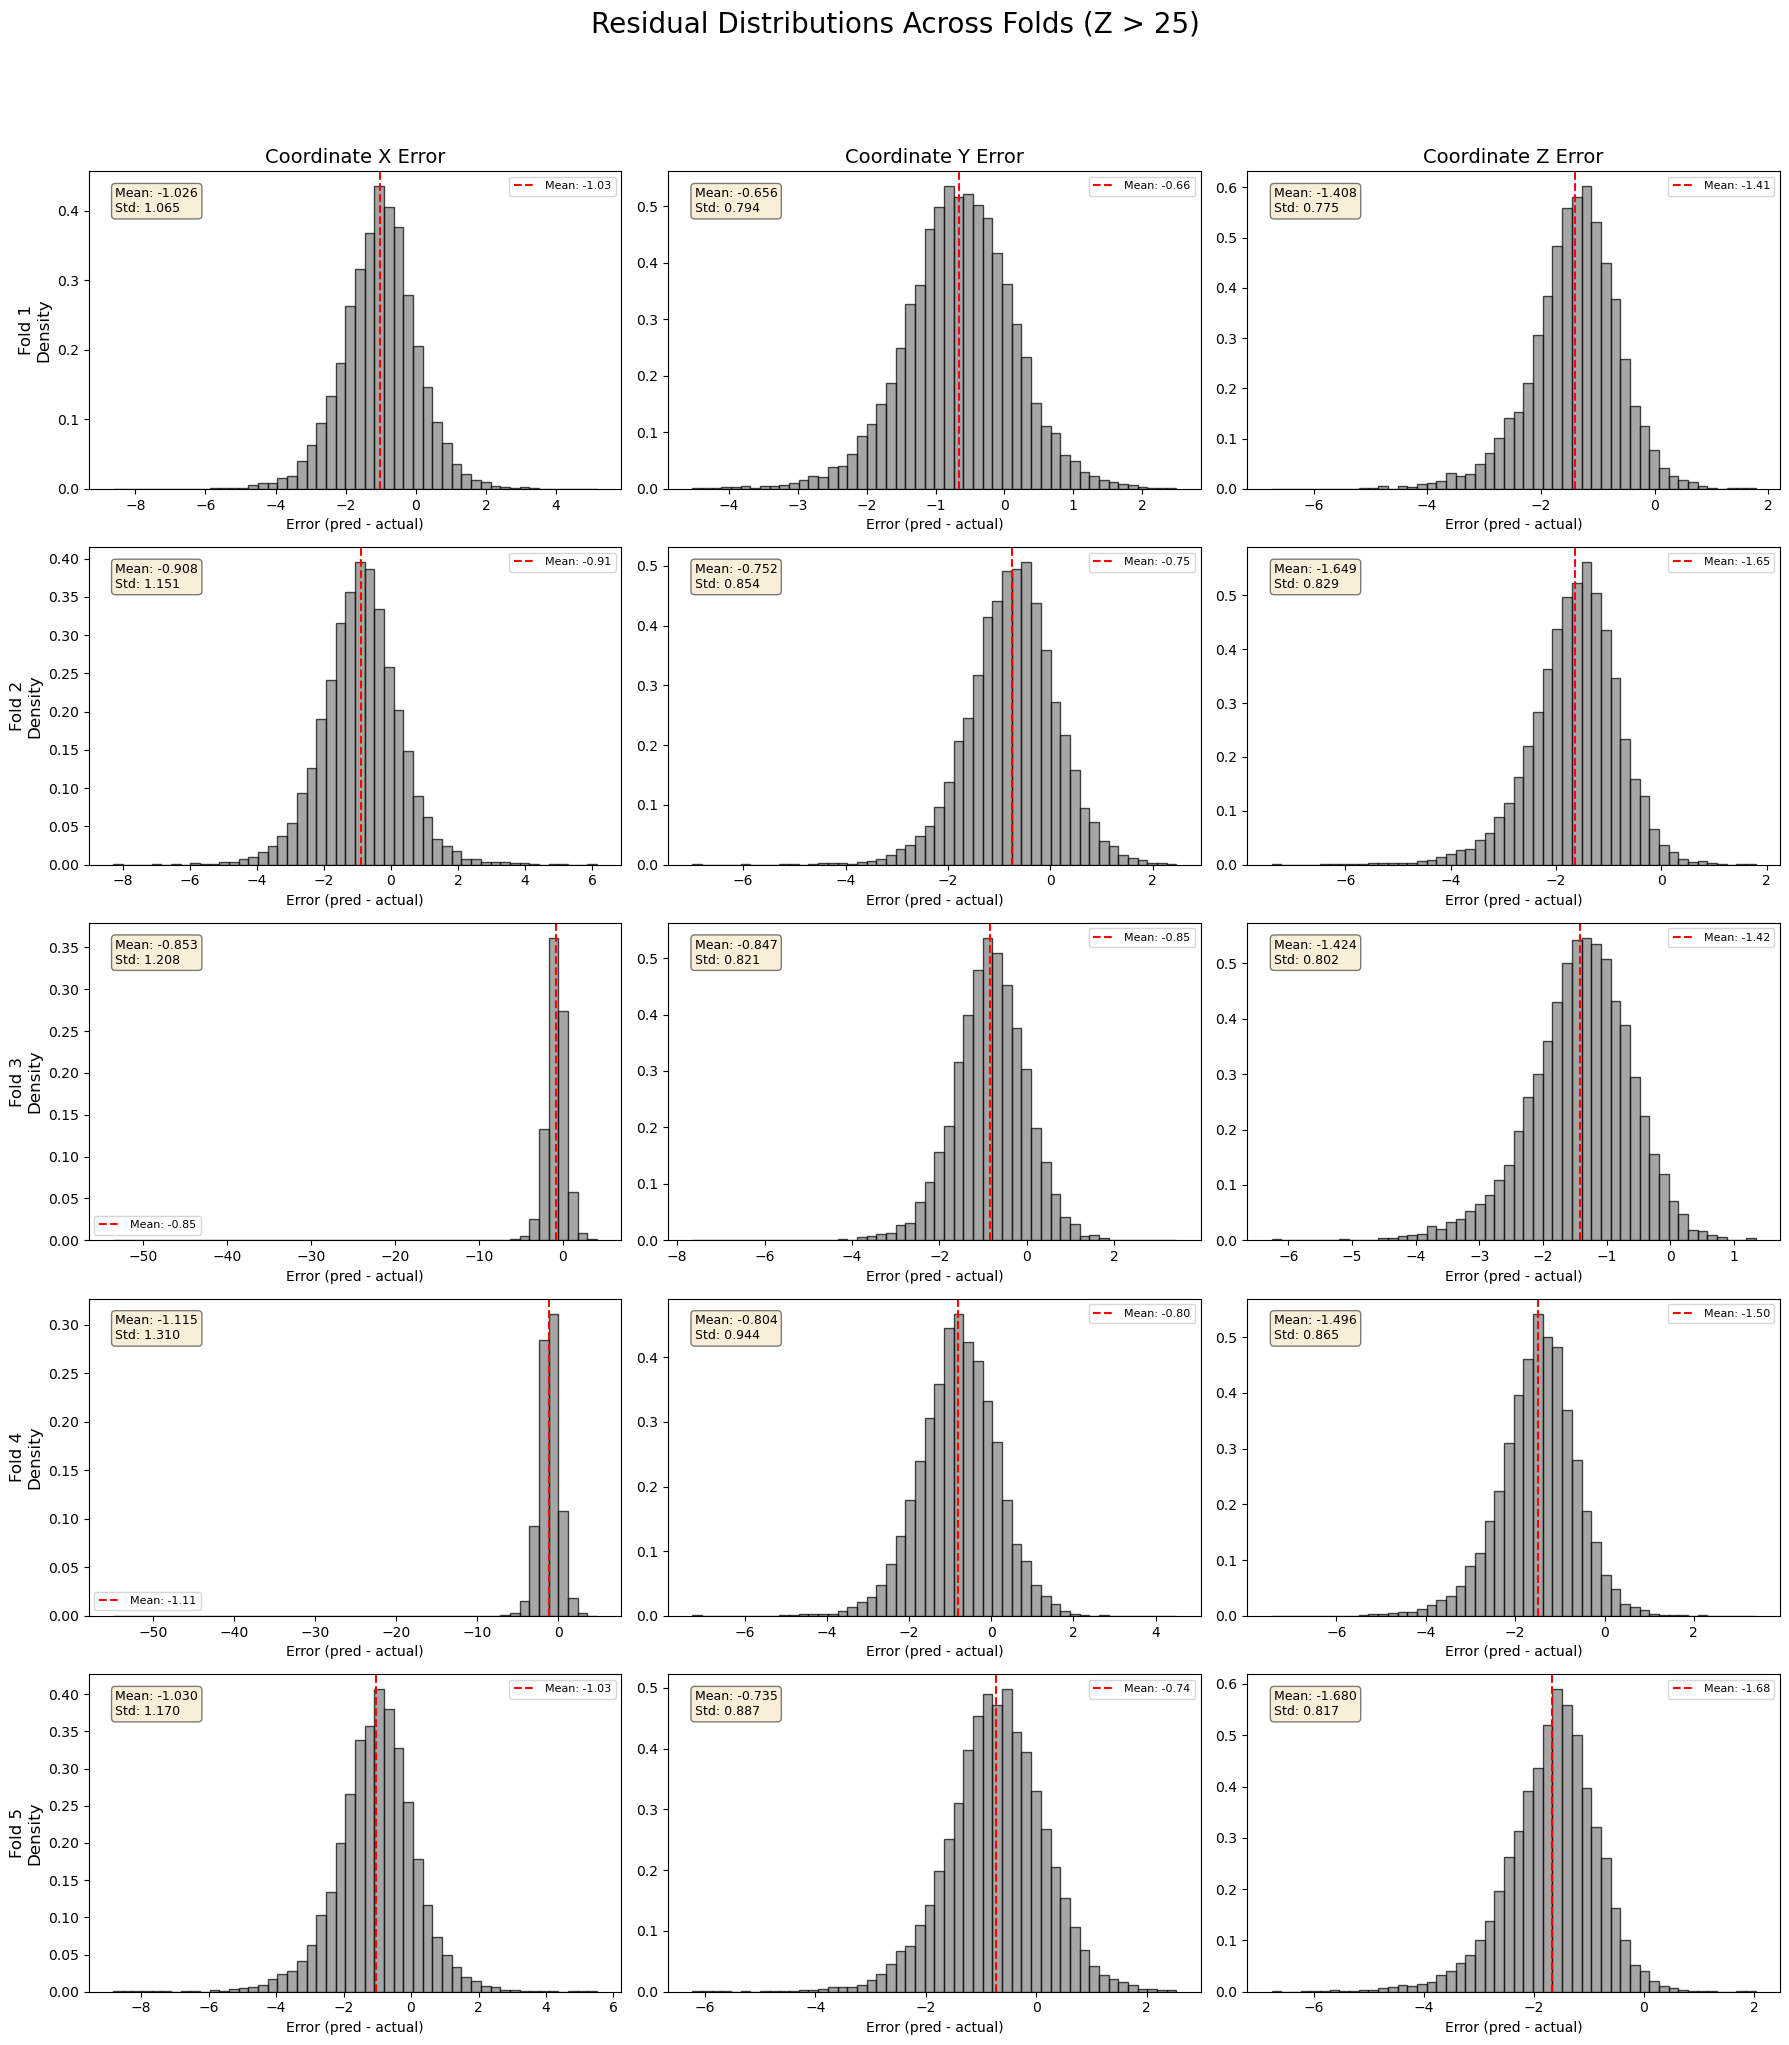

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# --- Setup ---
num_folds = len(folds)
shape = (data_zscored.shape[1], data_zscored.shape[2], data_zscored.shape[3])
n_genes = data_zscored.shape[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a figure with 5 rows (for folds) and 3 columns (for X, Y, Z)
fig, axes = plt.subplots(num_folds, 3, figsize=(18, 20))
fig.suptitle('Residual Distributions Across Folds (Z > 25)', fontsize=20, y=1.02)

# --- Main Loop ---
for fold_idx in range(num_folds):
    print(f"--- Processing Fold {fold_idx + 1}/{num_folds} ---")

    # 1. Load model
    model = PathwayVAE_cls_reg(num_genes=n_genes, latent_dim=200, shape=shape).to(device)
    model_path = f"pathway_vae_fold{fold_idx}.pt"
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # 2. Get test data and predictions
    test_dl = make_dataloader_collapsed(folds[fold_idx][2], n_genes, shape, batch_size=512, shuffle=False)
    
    actual_x, pred_x = [], []
    actual_y, pred_y = [], []
    actual_z, pred_z = [], []

    with torch.no_grad():
        for x_batch, z_batch, y_batch, x_pos_batch in test_dl:
            x_batch = x_batch.to(device)
            *_, x_reg, y_reg, z_reg = model(x_batch)
            
            tx, ty, tz = x_pos_batch.numpy(), y_batch.numpy(), z_batch.numpy()
            px, py, pz = x_reg.squeeze().cpu().numpy(), y_reg.squeeze().cpu().numpy(), z_reg.squeeze().cpu().numpy()
            
            mask = tz > 25
            if np.any(mask):
                actual_x.extend(tx[mask])
                pred_x.extend(px[mask])
                actual_y.extend(ty[mask])
                pred_y.extend(py[mask])
                actual_z.extend(tz[mask])
                pred_z.extend(pz[mask])

    # 3. Plot residuals for the current fold
    coords = [('X', actual_x, pred_x), ('Y', actual_y, pred_y), ('Z', actual_z, pred_z)]
    
    for col_idx, (name, actual, pred) in enumerate(coords):
        ax = axes[fold_idx, col_idx]
        if len(actual) > 0:
            errors = np.array(pred) - np.array(actual)
            mean_err, std_err = np.mean(errors), np.std(errors)
            
            ax.hist(errors, bins=50, density=True, alpha=0.7, color="gray", edgecolor="black")
            ax.axvline(mean_err, color="red", linestyle="--", label=f"Mean: {mean_err:.2f}")
            
            stats_text = f'Mean: {mean_err:.3f}\nStd: {std_err:.3f}'
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
                    verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))
        
        if fold_idx == 0:
            ax.set_title(f"Coordinate {name} Error", fontsize=14)
        if col_idx == 0:
            ax.set_ylabel(f"Fold {fold_idx+1}\nDensity", fontsize=12)
        ax.set_xlabel("Error (pred - actual)")
        ax.legend(fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()



--- Processing Fold 1/5 ---


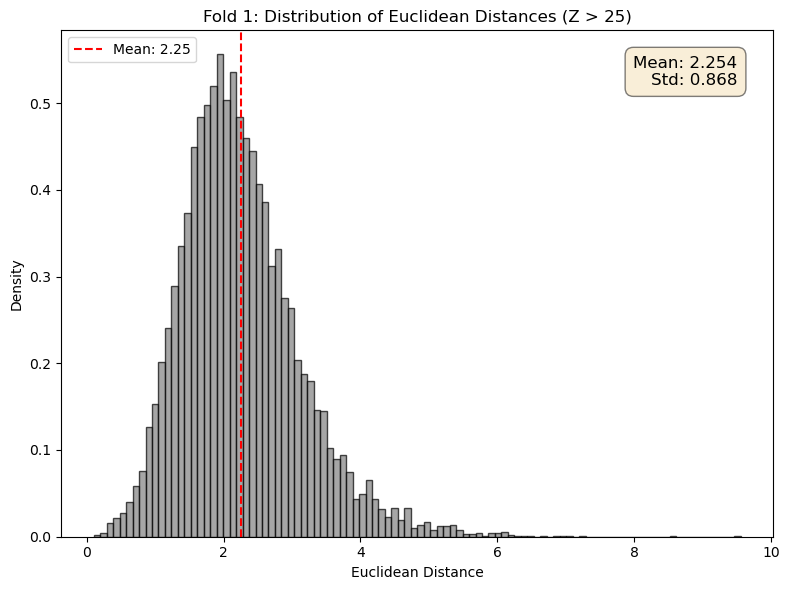


--- Processing Fold 2/5 ---


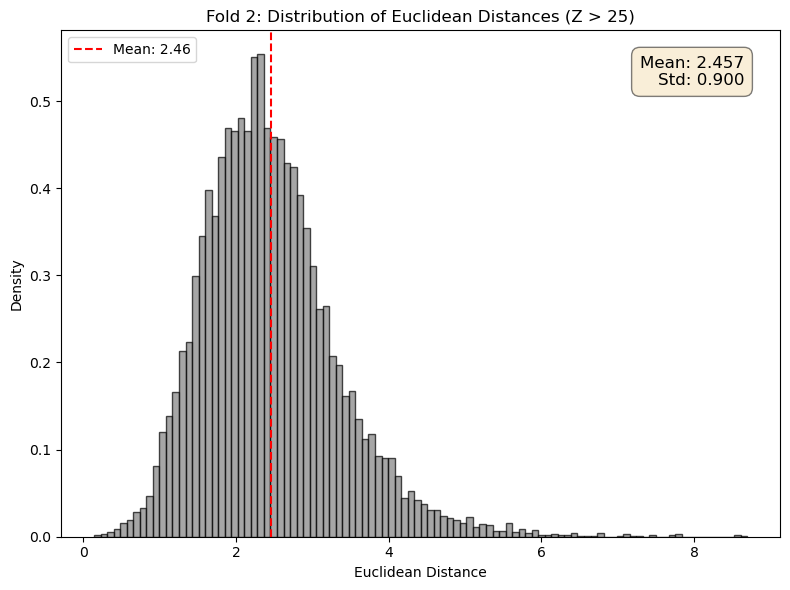


--- Processing Fold 3/5 ---


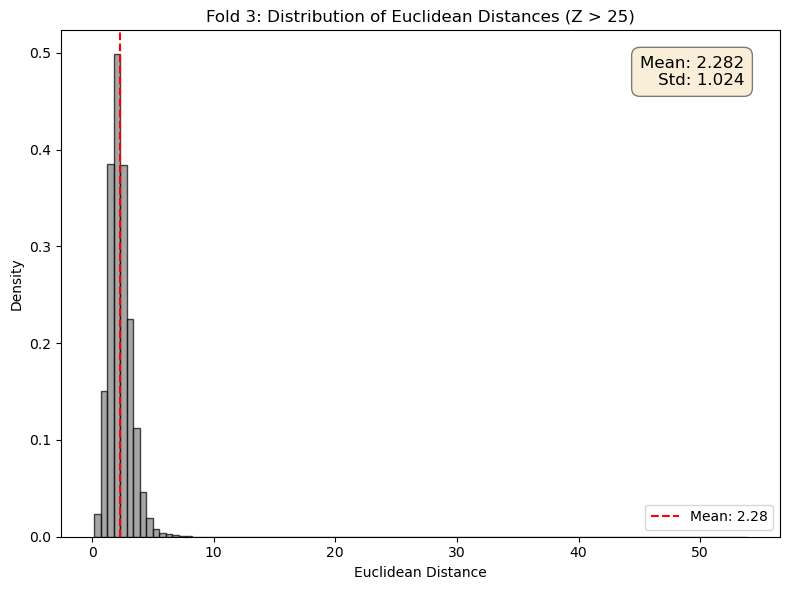


--- Processing Fold 4/5 ---


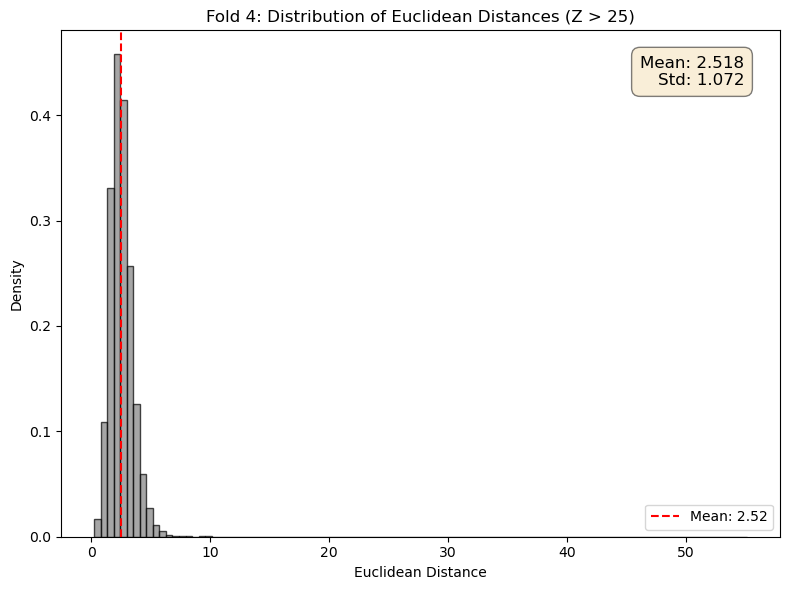


--- Processing Fold 5/5 ---


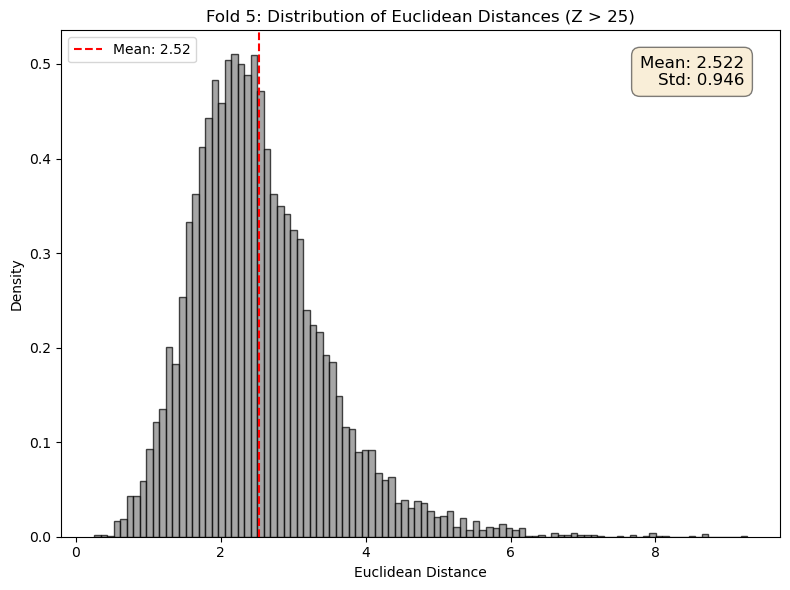

In [72]:
import numpy as np

import matplotlib.pyplot as plt
# --- Setup ---
num_folds = len(folds)
shape = (data_zscored.shape[1], data_zscored.shape[2], data_zscored.shape[3])
n_genes = data_zscored.shape[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def plot_euclidean_distance_stats(actual_x, actual_y, actual_z, pred_x, pred_y, pred_z, fold_idx, bins=100):
    """
    Calculates and plots the distribution of Euclidean distances between
    actual and predicted 3D positions, including summary statistics.
    """
    if not all(len(arr) > 0 for arr in [actual_x, actual_y, actual_z, pred_x, pred_y, pred_z]):
        print(f"Fold {fold_idx+1}: Not enough data to calculate Euclidean distance.")
        return None

    actual_positions = np.stack([actual_x, actual_y, actual_z], axis=1)
    predicted_positions = np.stack([pred_x, pred_y, pred_z], axis=1)
    distances = np.linalg.norm(predicted_positions - actual_positions, axis=1)

    mean_dist = np.mean(distances)
    std_dist = np.std(distances)
    stats_text = f'Mean: {mean_dist:.3f}\nStd: {std_dist:.3f}'

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.hist(distances, bins=bins, density=True, alpha=0.7, color="gray", edgecolor="black")
    ax.axvline(mean_dist, color="red", linestyle="--", label=f"Mean: {mean_dist:.2f}")
    # Add stats text to the plot
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

    ax.set_title(f"Fold {fold_idx+1}: Distribution of Euclidean Distances (Z > 25)")
    ax.set_xlabel("Euclidean Distance")
    ax.set_ylabel("Density")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    return distances

# --- Main Loop ---
for fold_idx in range(num_folds):
    print(f"\n--- Processing Fold {fold_idx + 1}/{num_folds} ---")

    # 1. Load model
    model = PathwayVAE_cls_reg(num_genes=n_genes, latent_dim=200, shape=shape).to(device)
    model_path = f"pathway_vae_fold{fold_idx}.pt"
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # 2. Get test data and predictions
    test_dl = make_dataloader_collapsed(folds[fold_idx][2], n_genes, shape, batch_size=512, shuffle=False)
    
    actual_x, pred_x = [], []
    actual_y, pred_y = [], []
    actual_z, pred_z = [], []

    with torch.no_grad():
        for x_batch, z_batch, y_batch, x_pos_batch in test_dl:
            x_batch = x_batch.to(device)
            *_, x_reg, y_reg, z_reg = model(x_batch)
            
            tx, ty, tz = x_pos_batch.numpy(), y_batch.numpy(), z_batch.numpy()
            px, py, pz = x_reg.squeeze().cpu().numpy(), y_reg.squeeze().cpu().numpy(), z_reg.squeeze().cpu().numpy()
            
            mask = tz > 25
            if np.any(mask):
                actual_x.extend(tx[mask])
                pred_x.extend(px[mask])
                actual_y.extend(ty[mask])
                pred_y.extend(py[mask])
                actual_z.extend(tz[mask])
                pred_z.extend(pz[mask])

    # 3. Plot Euclidean distance for the current fold
    euclidean_distances = plot_euclidean_distance_stats(
        actual_x, actual_y, actual_z, 
        pred_x, pred_y, pred_z, 
        fold_idx
    )